# Classification – Detecting Poor Answers
## Sketching our roadmap
## Learning to classify classy answers
## Fetching the data
### Slimming the data down to chewable chunks
### Preselection and processing of attributes

In [1]:
import os
import re
from collections import defaultdict
try:
    import ujson as json  # UltraJSON if available
except:
    print("We can also use the normal json module, but ujson is faster to parse.")
    raise

In [2]:
DATA_DIR = r'data' # Posts.xml is in this directory

YEAR = 2020 # It will restrict the data to posts from this year

In [3]:
filename_posts_all = os.path.join(DATA_DIR, "Posts.xml")
print("Reading from xml %s" % filename_posts_all)

Reading from xml data\Posts.xml


In [4]:
filename_posts = os.path.join(DATA_DIR, "posts-%i.xml" % YEAR)
print("Restricting the data to just year 2020 from xml %s" % filename_posts)

Restricting the data to just year 2020 from xml data\posts-2020.xml


In [5]:
filename_filtered = os.path.join(DATA_DIR, "filtered-%i.tsv" % YEAR)
print("Filtered: %s" % filename_filtered)

Filtered: data\filtered-2020.tsv


In [6]:
filename_filtered_meta = os.path.join(DATA_DIR, "filtered-%i-meta.json" % YEAR)
print("Meta: %s" % filename_filtered_meta)

Meta: data\filtered-2020-meta.json


In [7]:
SAMPLE_DIR = '%i' % YEAR
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

if not os.path.exists(os.path.join(SAMPLE_DIR, 'data')):
    os.mkdir(os.path.join(SAMPLE_DIR, 'data'))

In [8]:
filename_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample.tsv"))
print("sample posts: %s" % filename_sample)

sample posts: D:\Study-resource\7th SEM\Machine Learning - COMP484\Lab\Lab 5\2020\data\sample.tsv


In [9]:
filename_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample-meta.json"))
print("sample meta: %s" % filename_sample_meta)

sample meta: D:\Study-resource\7th SEM\Machine Learning - COMP484\Lab\Lab 5\2020\data\sample-meta.json


In [10]:
CHART_DIR = os.path.join(SAMPLE_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

In [11]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(filename_posts_all)

In [12]:
def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))

In [13]:
print("Extracting all posts from %i ..." % YEAR)
with open(filename_posts_all, 'r', encoding='utf-8') as fa, open(filename_posts, 'w', encoding='utf-8') as f_year:
    # first two lines are the xml header and <posts> tag
    f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')    
    
    right = size//2
    delta = right
    
    # first find some post of YEAR
    while True:
        fa.seek(right)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year>YEAR:
            right -= delta
        elif year<YEAR:
            right += delta
        else:
            break
            
    # then find where it starts
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
            
        else:
            left, right = left-delta, left
    
    # and write all posts of that year
    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f_year.write(line)
        elif year is None or year > YEAR:
            break
        
    # and write the closing tag
    f_year.write('</posts>')
print('... done!')

Extracting all posts from 2020 ...
... done!


In [14]:
from dateutil import parser as dateparser
from operator import itemgetter
from lxml import etree

In [15]:
filtered_meta = {
    'question': {}, # question -> [(answer Id, Score), ...]
    'total': 0 # questions and answers finally written
}

In [16]:
# Regular expressions to find code snippets, links, and tags, which might help in designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
img_match = re.compile('<img(.*?)/>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

In [17]:
# This method designs features from the raw post. 
def extract_features_from_body(s):
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s
    
    num_images = len(img_match.findall(s))

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count, num_images

In [18]:
num_questions = 0
num_answers = 0

def parsexml(filename):
    global num_questions, num_answers

    counter = 0

    # iterparse() returns a tuple (event, element). Since we request only 'start' events, 
    # we pipe the result through an itemgetter that always returns the 2nd result.
    it = map(itemgetter(1), etree.iterparse(filename, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for elem in it:
        if counter % 100000 == 0:
            print("Processed %i <row/> elements" % counter)

        counter += 1
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = extract_features_from_body(elem.get('Body'))

        # We have to tell lxml that this element is not used anymore. Otherwise, memory will blow up.
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text, NumImages)

        yield values

In [19]:
if any(not os.path.exists(filename) for filename in [filename_filtered, filename_filtered_meta]):
    total = 0
    with open(filename_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(filename_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(filename_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#questions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % filename_filtered_meta)
    filtered_meta = json.load(open(filename_filtered_meta, "r"))
    print("... done!")

Processed 0 <row/> elements
Processed 100000 <row/> elements
Processed 200000 <row/> elements
Processed 300000 <row/> elements
Processed 400000 <row/> elements
Processed 500000 <row/> elements
Processed 600000 <row/> elements
Processed 700000 <row/> elements
Processed 800000 <row/> elements
Processed 900000 <row/> elements
Processed 1000000 <row/> elements
Processed 1100000 <row/> elements
Processed 1200000 <row/> elements
Processed 1300000 <row/> elements
Processed 1400000 <row/> elements
Processed 1500000 <row/> elements
Processed 1600000 <row/> elements
Processed 1700000 <row/> elements
Processed 1800000 <row/> elements
Processed 1900000 <row/> elements
Processed 2000000 <row/> elements
Processed 2100000 <row/> elements
Processed 2200000 <row/> elements
Processed 2300000 <row/> elements
Processed 2400000 <row/> elements
Processed 2500000 <row/> elements
Processed 2600000 <row/> elements
Processed 2700000 <row/> elements
Processed 2800000 <row/> elements
Processed 2900000 <row/> elem

### Defining what is a good answer

In [22]:
NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

# Sorting the questions before iterating over them is only done for reproducability.
for ParentId, posts in sorted(question.items()):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if found_questions >= NUM_QUESTION_SAMPLE:
        break

In [23]:
already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(filename_sample, "w", encoding='utf-8') as f:
    for line in open(filename_filtered, 'r', encoding='utf-8'):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text, NumImages = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['NumImages'] = int(NumImages)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(filename_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)

read: 4265930
kept: 30000


In [25]:
def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

In [26]:
meta = load_meta(filename_sample_meta)

### Loading the features and labeling them

In [27]:
all_answers = sorted([a for a, v in meta.items() if v['ParentId'] != -1])

An answer is labeled as positive if it has a score greater than zero and as negative if it has a score less than or equal to zero.

In [29]:
import numpy as np

Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))

(array([False,  True]), array([10000, 10000], dtype=int64))


## Creating our first classifier
### Starting with kNN

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = neighbors.KNeighborsClassifier(n_neighbors=2)
print(knn)

KNeighborsClassifier(n_neighbors=2)


In [56]:
# Training it using fit()
knn.fit([[1],[2],[3],[4],[5],[6]], [0,0,0,1,1,1])

KNeighborsClassifier(n_neighbors=2)

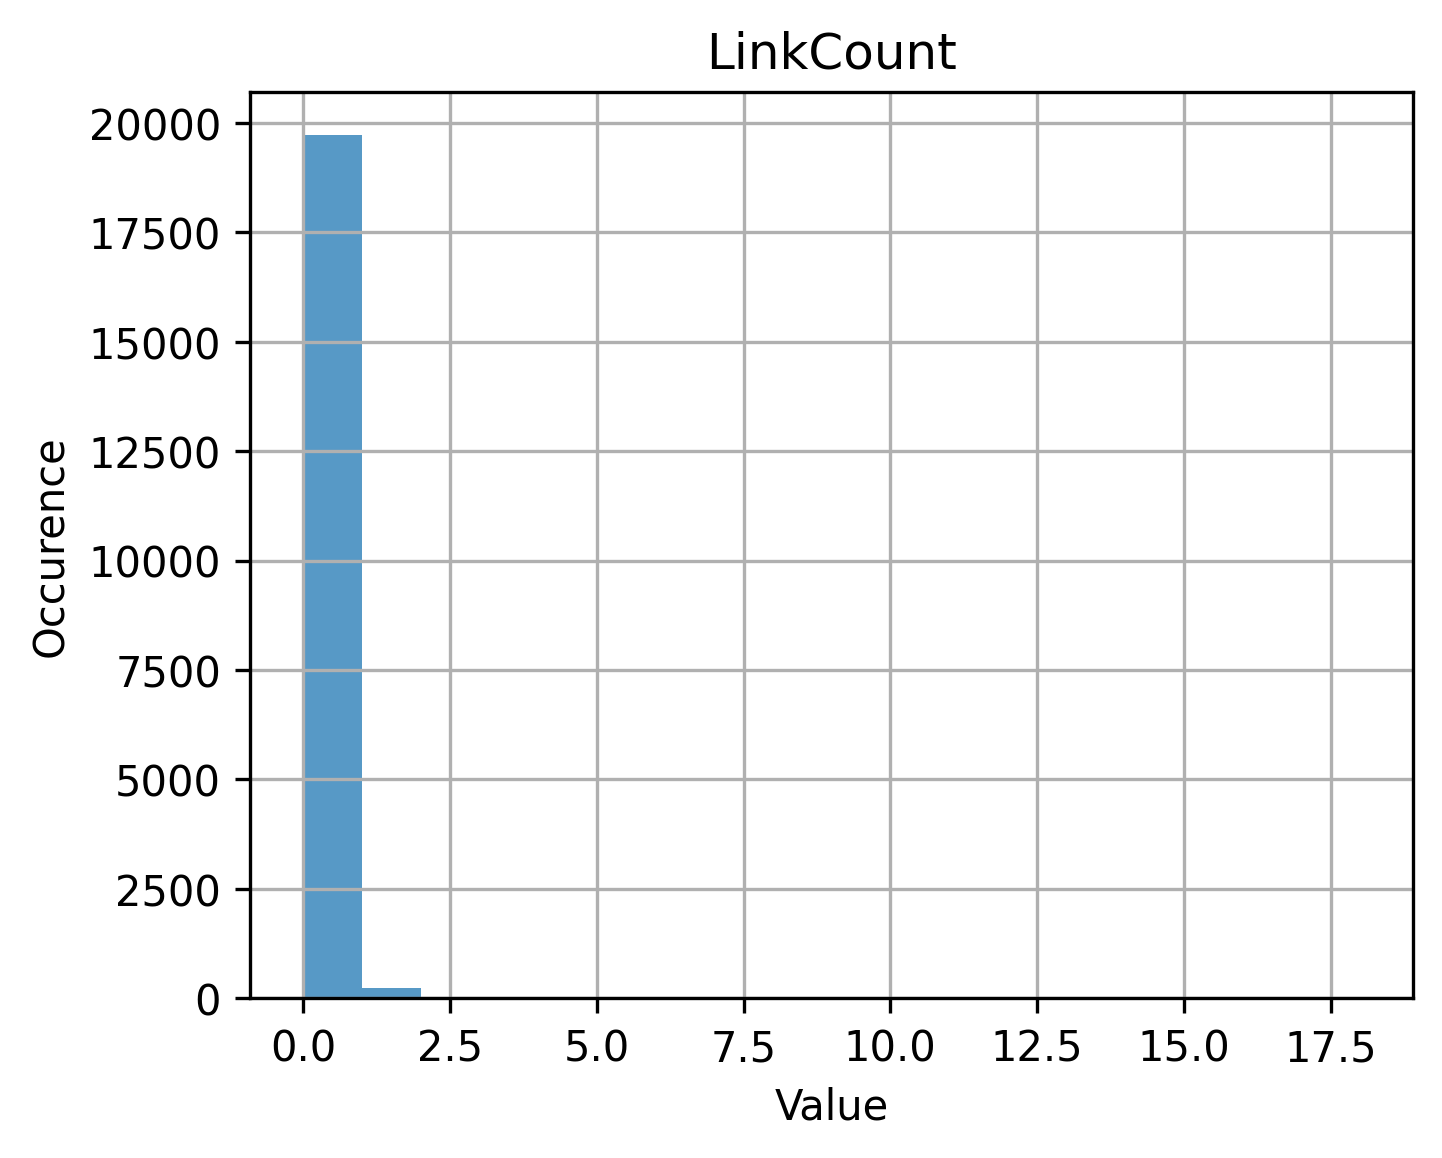

In [76]:
import matplotlib.pyplot as plt

# Plotting the percentage of how often each value of LinkCount as a feature occurs in the data
X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=300) # width and height of the plot in inches

plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurence')

n, bins, patches = plt.hist(X, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)

With the majority of posts having no link at all, we know now that this feature will not make a good classifier. Let's try it out anyway to get a first estimation of where we are.

## Training the classifier

In [71]:
# Using accuracy as the prediction quality and applying cross-validation method
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

scores = []
for train, test in cv.split(X, Y):
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

Mean(scores)=0.50260	Stddev(scores)=0.01063


With only 55 percent accuracy, it is not much better than tossing a coin. Apparently, the number of links in a post is not a very good indicator for the quality of a post. So, we can say that this feature does not have much discriminative power—at least not for kNN with k=5.

## Using more features we created before

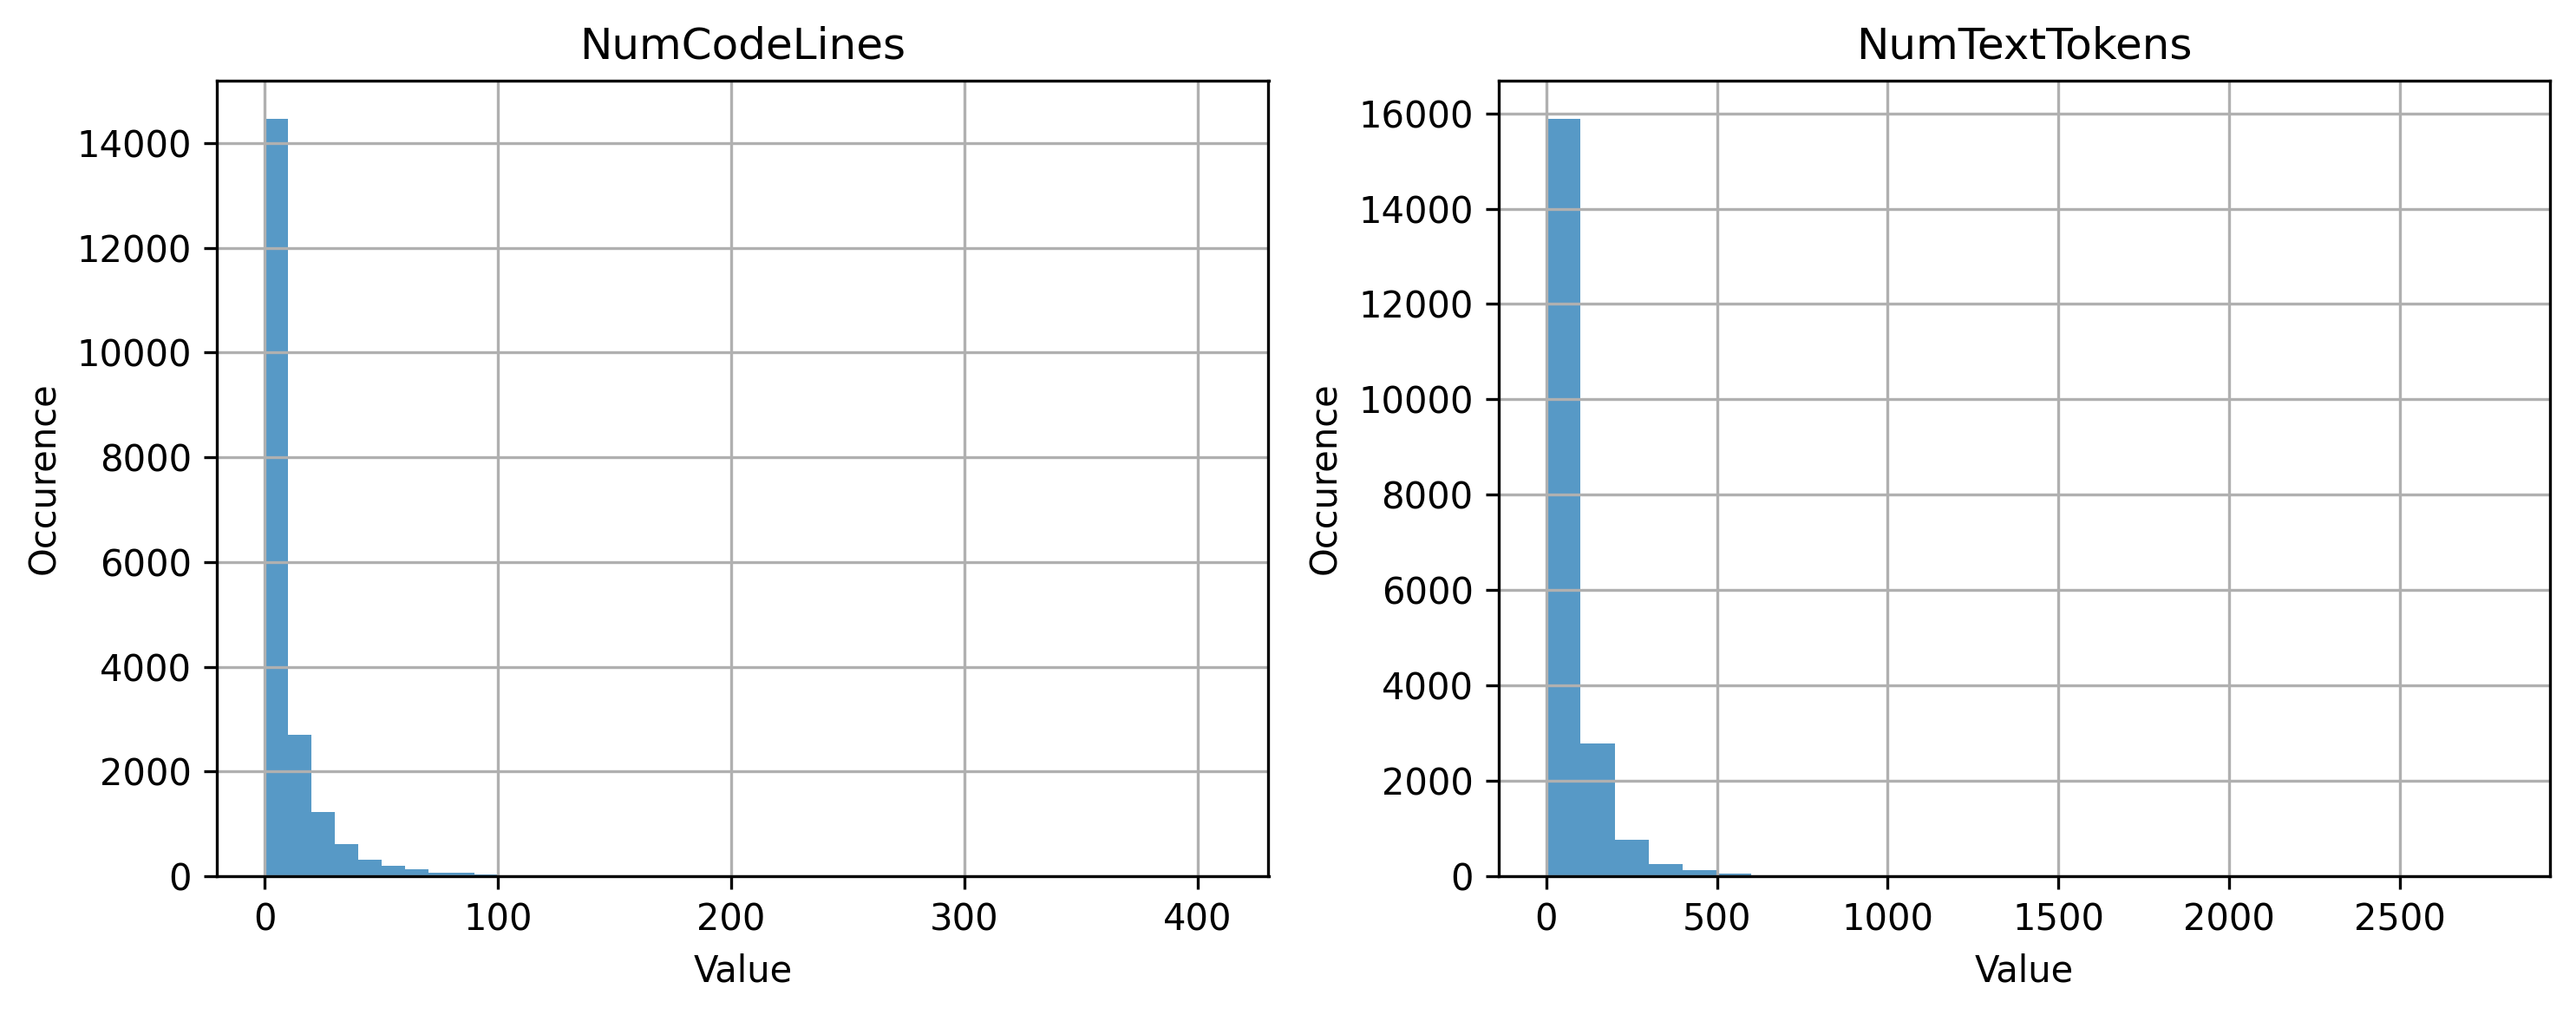

In [75]:
def plot_features_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    
    if not filename:
        filename = "feat_hist_%s" % name.replace(" ", "_")

plot_features_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')], '02_feat_hist_CodeLines_TextTokens');

Since the features vary in their value ranges, we need to standardize them using `StandardScaler()` so that kNN does not bias towards features having larger value intervals. 

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [78]:
def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

In [80]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in cv.split(X, Y):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

Mean(scores)=0.58905	Stddev(scores)=0.00989


Training on the bigger feature space improves accuracy quite a bit, but still the accuracy is not that great. Therefore, let's extend the feature space by even more features.

## Designing more features

In [83]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\praab\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [84]:
def fetch_posts(fn):
    for line in open(fn, 'r', encoding='utf-8'):
        post_id, text = line.split('\t')
        yield int(post_id), text.strip()

In [85]:
def add_sentence_features(m):
    for pid, text in fetch_posts(filename_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

In [86]:
add_sentence_features(meta)

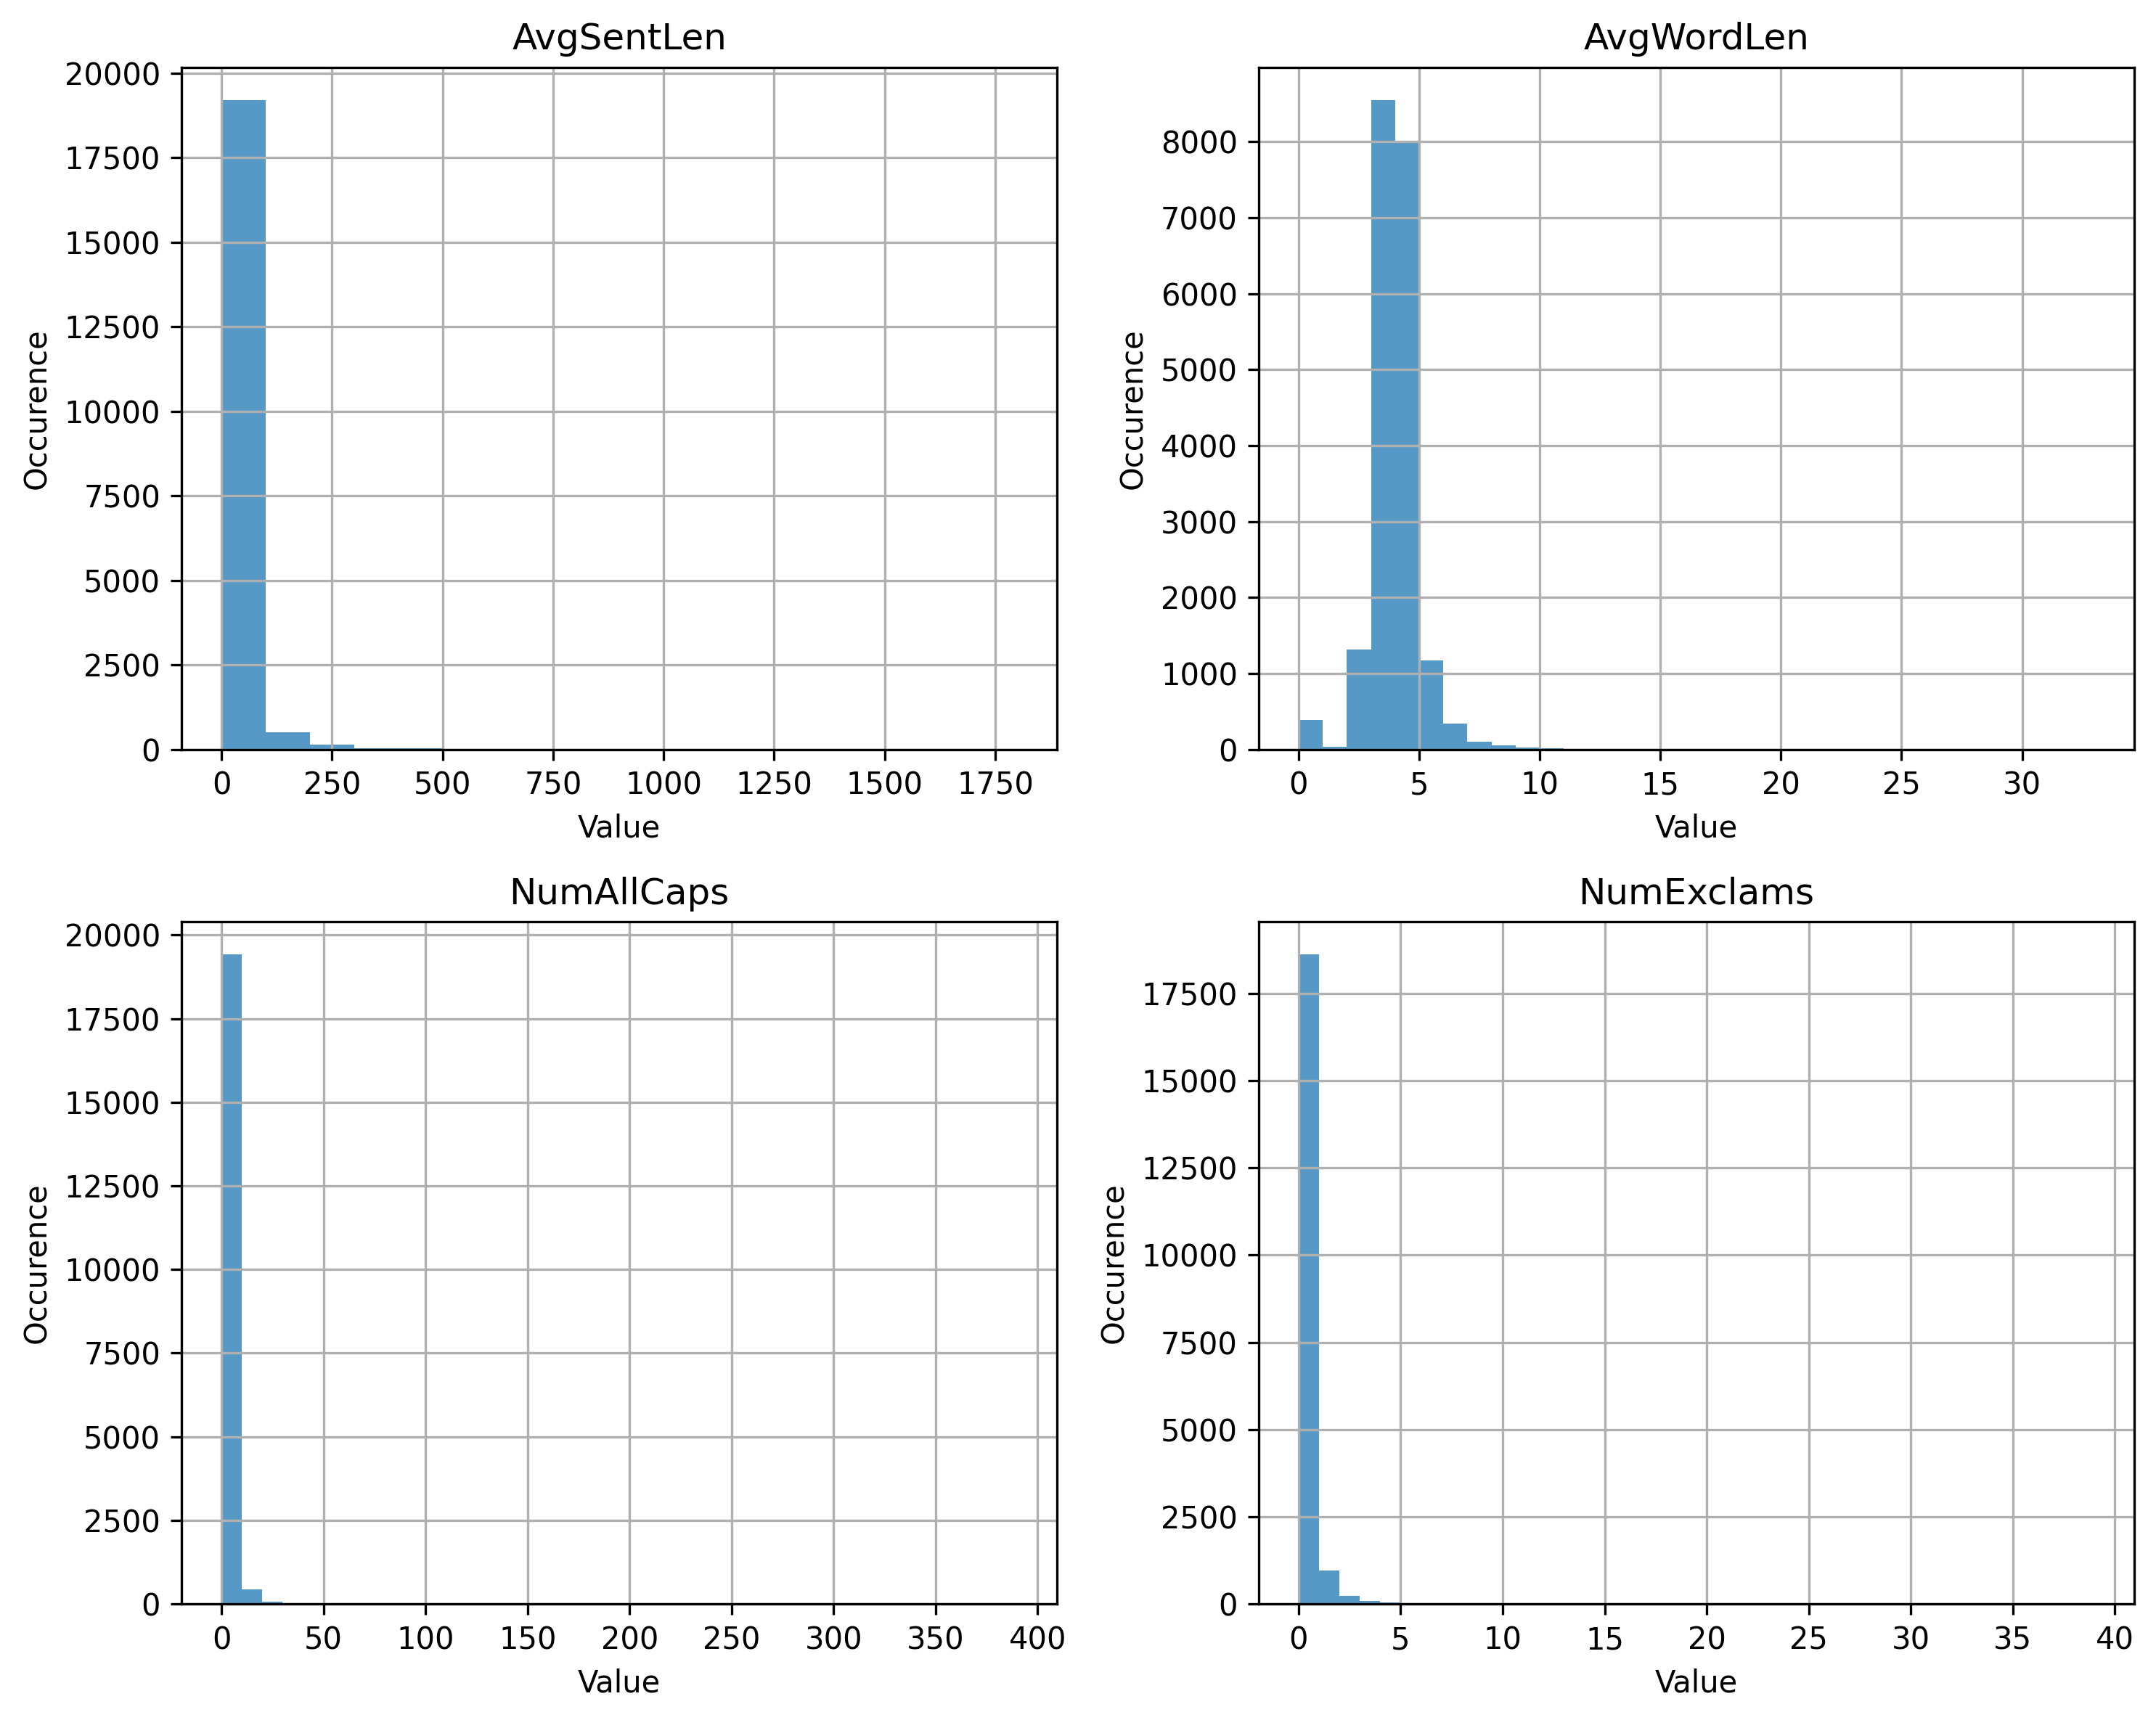

In [88]:
plot_features_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams');

In [89]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in cv.split(X, Y):    
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 

Mean(scores)=0.59720	Stddev(scores)=0.00810


We added four more features and don't get any improvement in accuracy. Clearly, kNN has a hard time in correctly using the available data.

## Bias-variance and their tradeoff
### High bias or low bias
#### Plotting the train and test errors over the data size to find out what our problem is.

In [99]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

In [100]:
def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance for '%s'" % name)
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

In [101]:
def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")+'_pr'

In [102]:
def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)
    
    plt.title('Feature importance for %s' % (name.split('_')[-1]))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")+'_feat_imp'

In [103]:
def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        if False:
            print("Clone #%i" % fold_idx)
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], plot + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {'name': name,
               'scores': scores,
               'roc_scores': roc_scores,
               'pr_scores': pr_scores,
               'med_precisions': precisions[medium], 
               'med_recalls': recalls[medium], 
               'med_thresholds': thresholds[medium]}
    
    return np.mean(train_errors), np.mean(test_errors), summary

In [104]:
def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

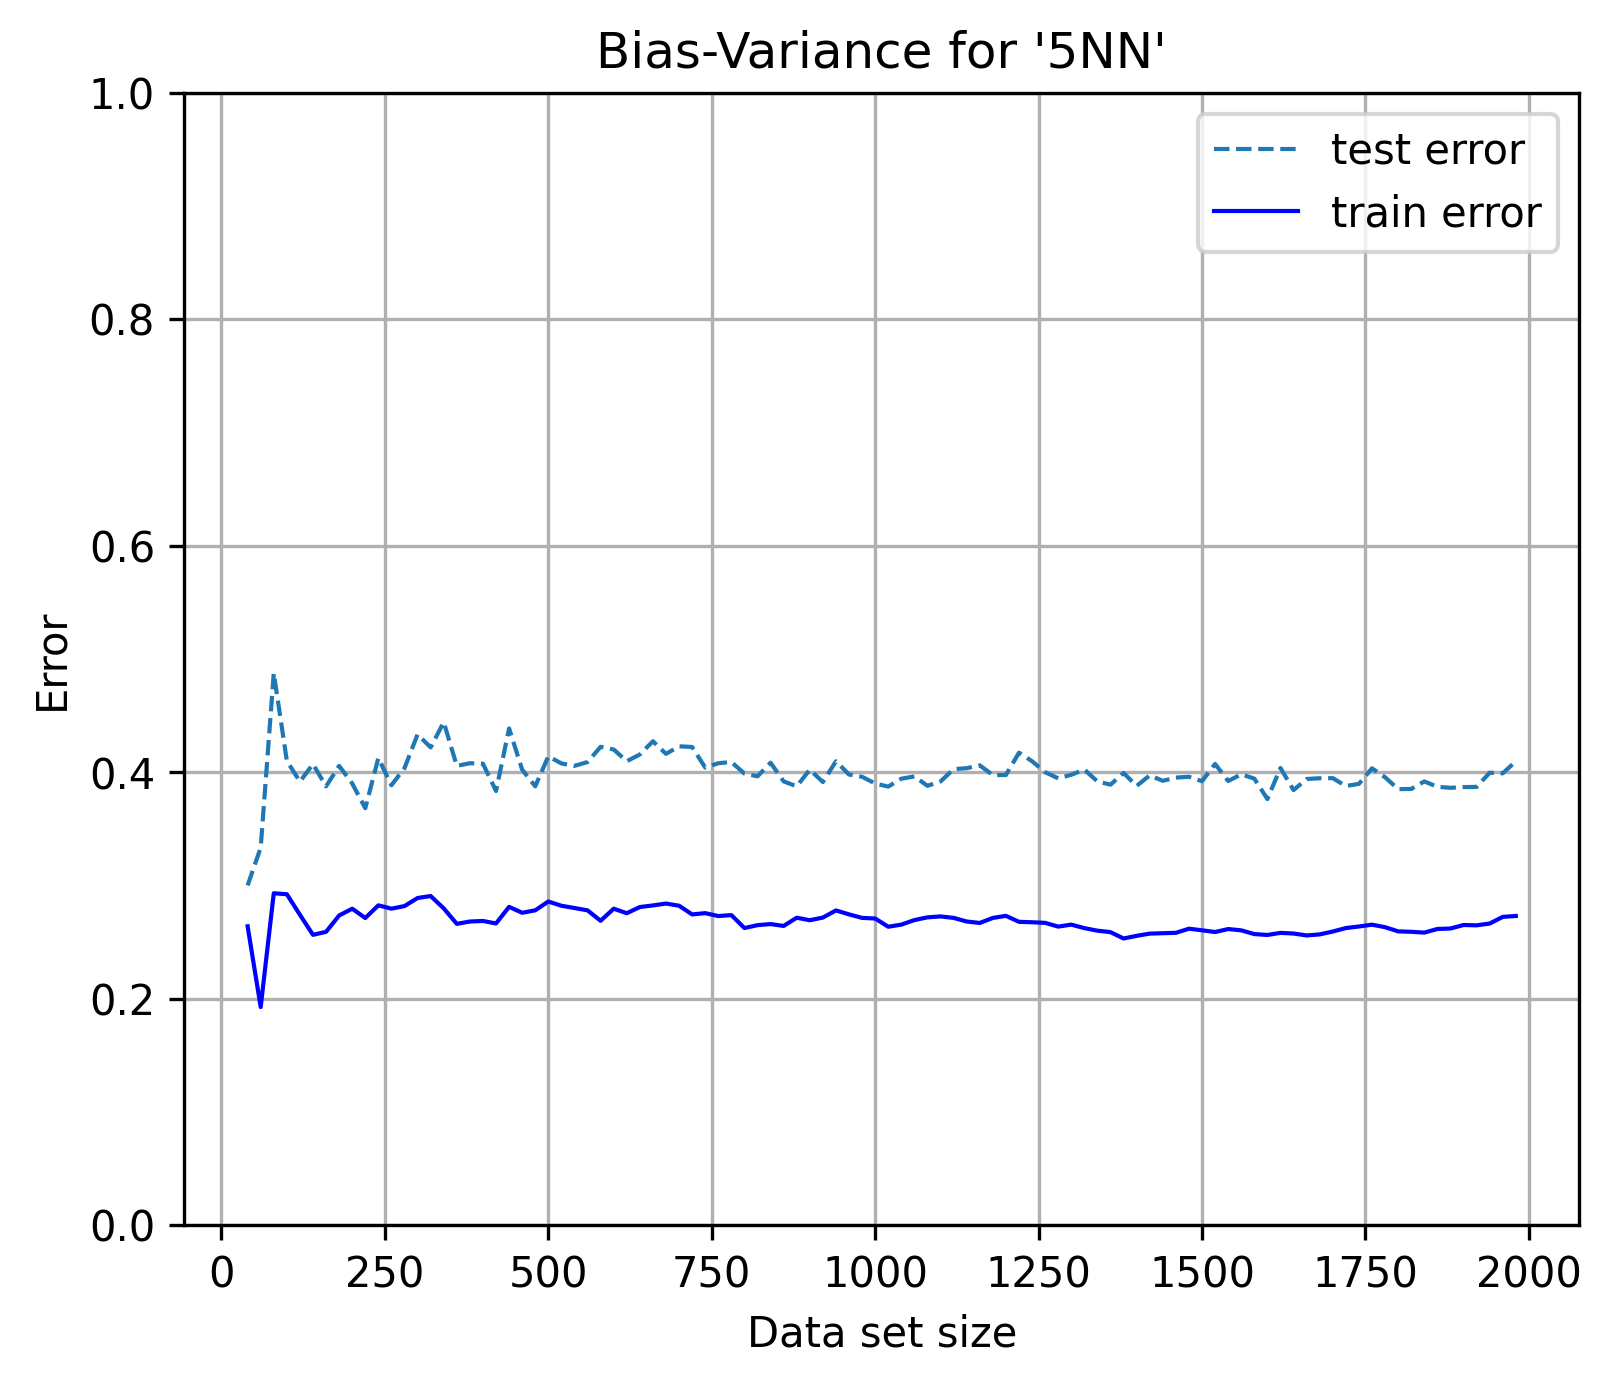

In [105]:
def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)

Plotting the errors for different dataset sizes for 5NN shows a big gap between train and test errors, indicating a high variance problem.

#### Plotting the graph for a simplified feature space of only LinkCount and NumTextTokens.

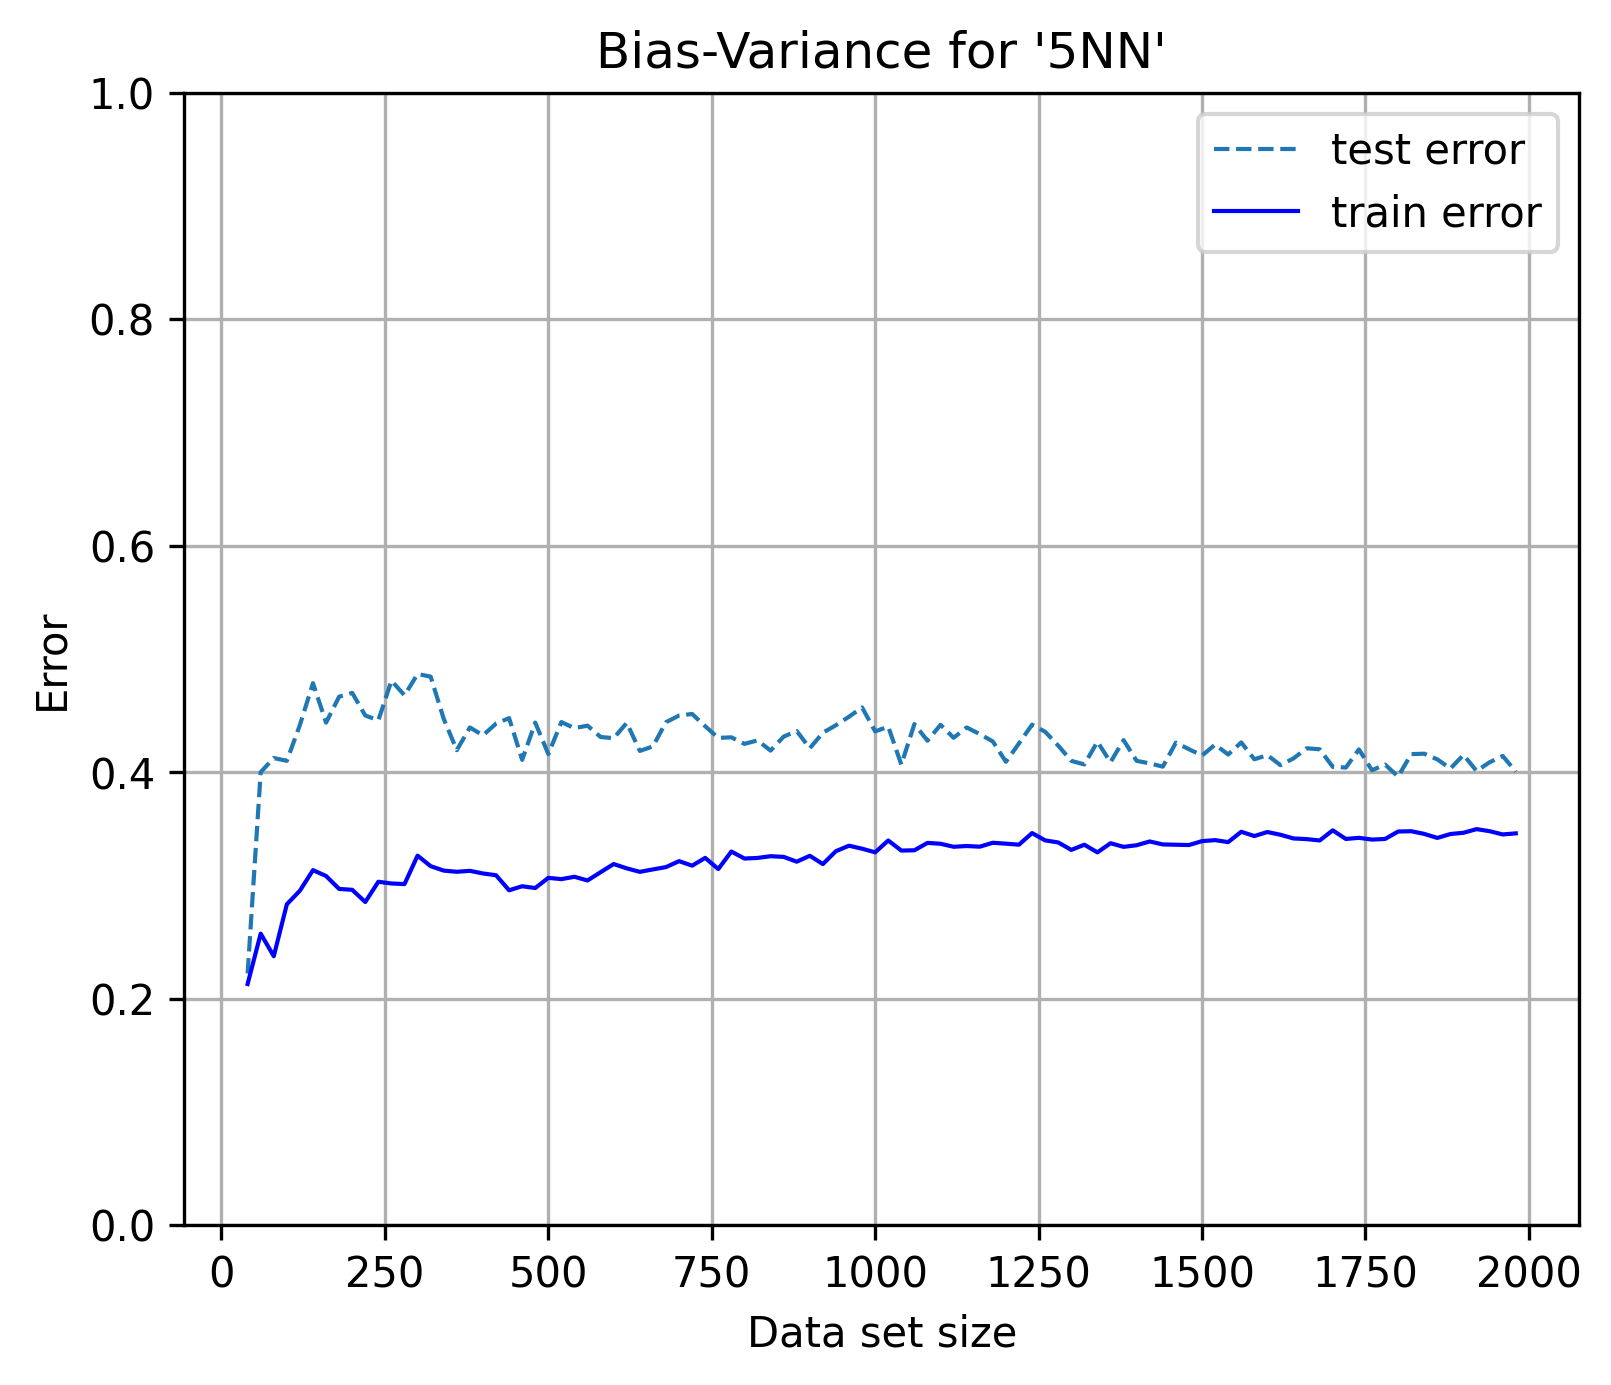

In [106]:
from sklearn.utils import shuffle

X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)

Since there is still a big gap between train and test errors, reducing the feature space does not help here.

#### Another way to reduce the model complexity is to increase k.

In [107]:
print('k\tmean(scores)\tstddev(scores)')

for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, "%iNN" % k, X, Y)
    print('%d\t%.4f\t\t%.4f' % (k, np.mean(summary['scores']), np.std(summary['scores'])))

k	mean(scores)	stddev(scores)
5	0.5972		0.0081
10	0.6096		0.0092
40	0.6329		0.0106


At least reducing the model complexity by increasing k shows some positive impact. But it is not enough, and also comes at a price of lower classification runtime performance.

#### Plotting the graph of train and test errors over different values of k.

In [108]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

In [109]:
def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)

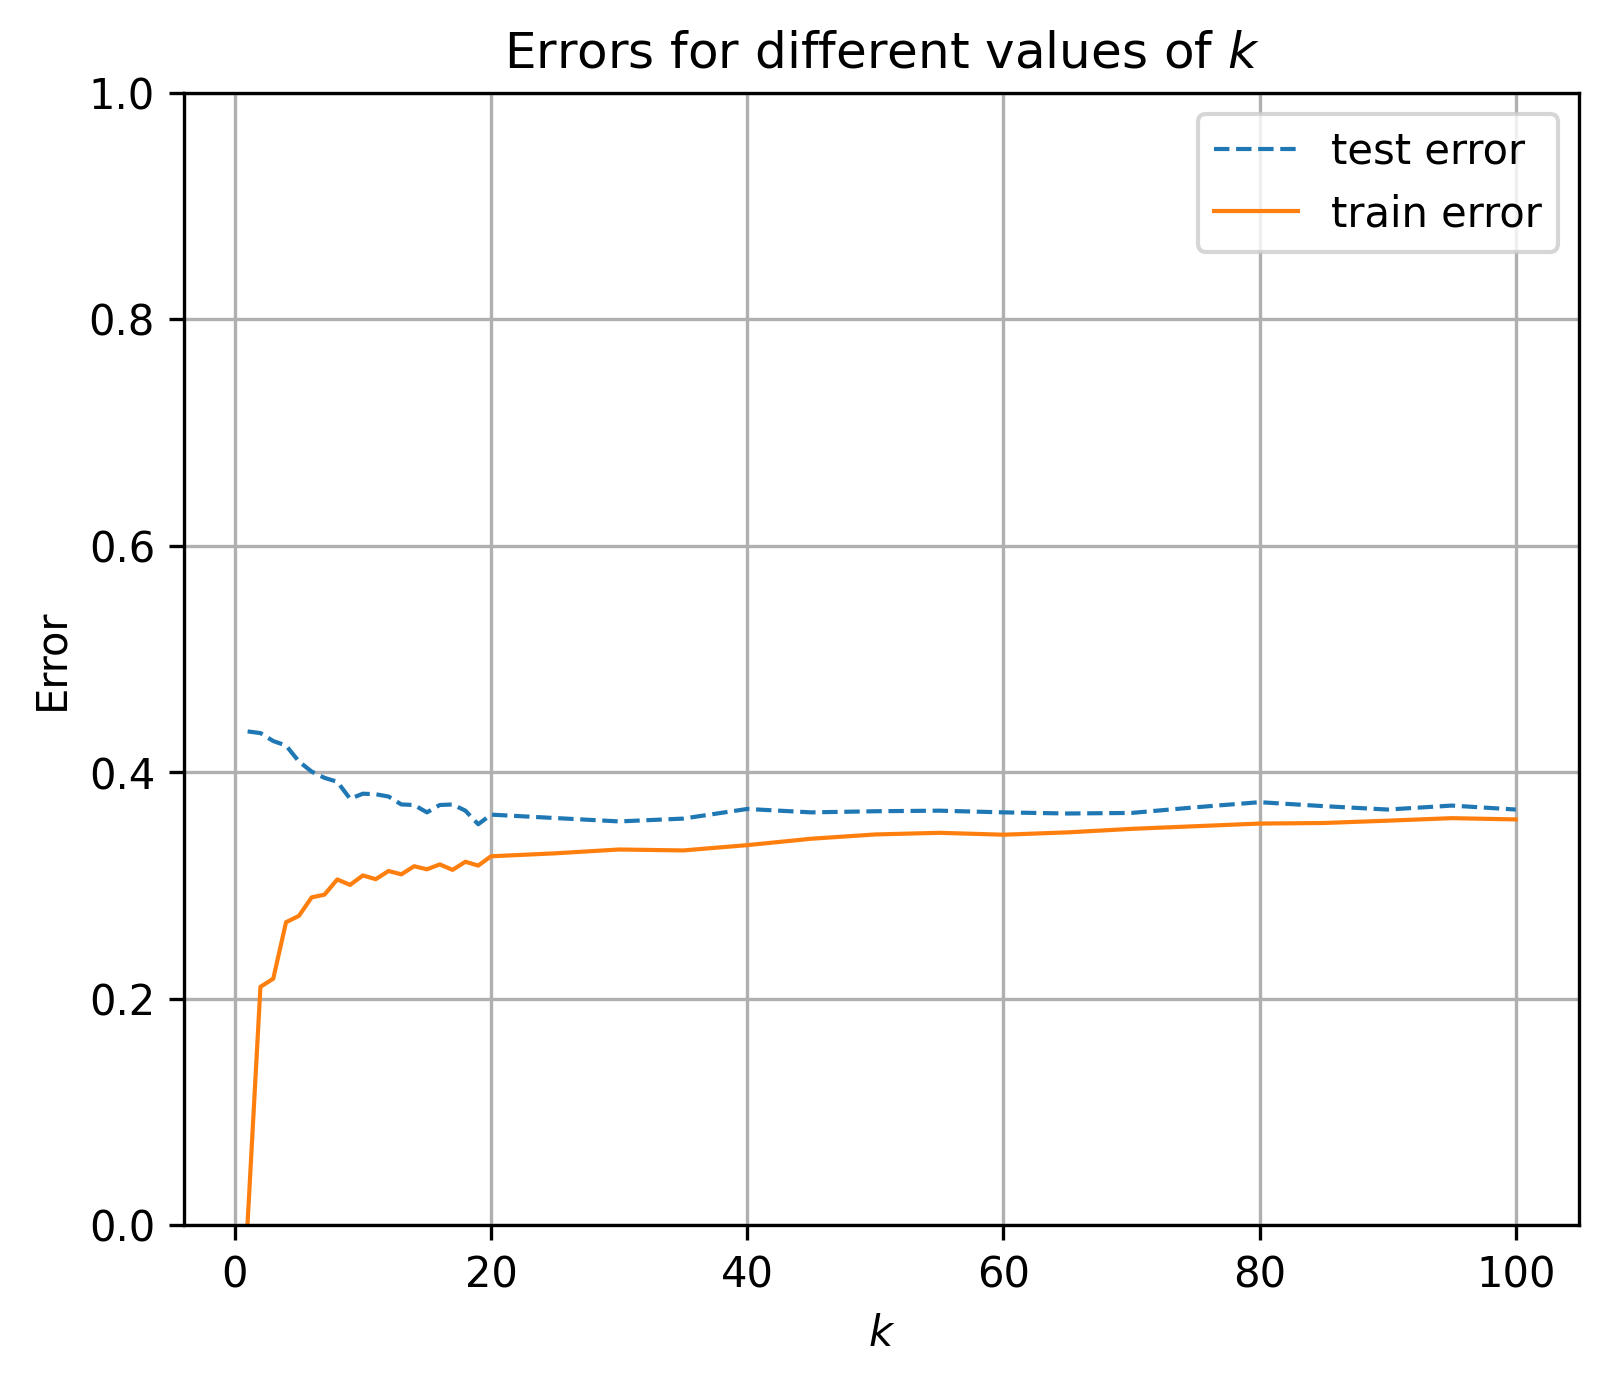

In [110]:
k_complexity_analysis(create_pipeline, X, Y)  

## Using logistic regression
### A bit of math with a small example

In [111]:
from scipy.stats import norm

In [113]:
np.random.seed(3) # for reproducibility

Text(0, 0.5, 'Class')

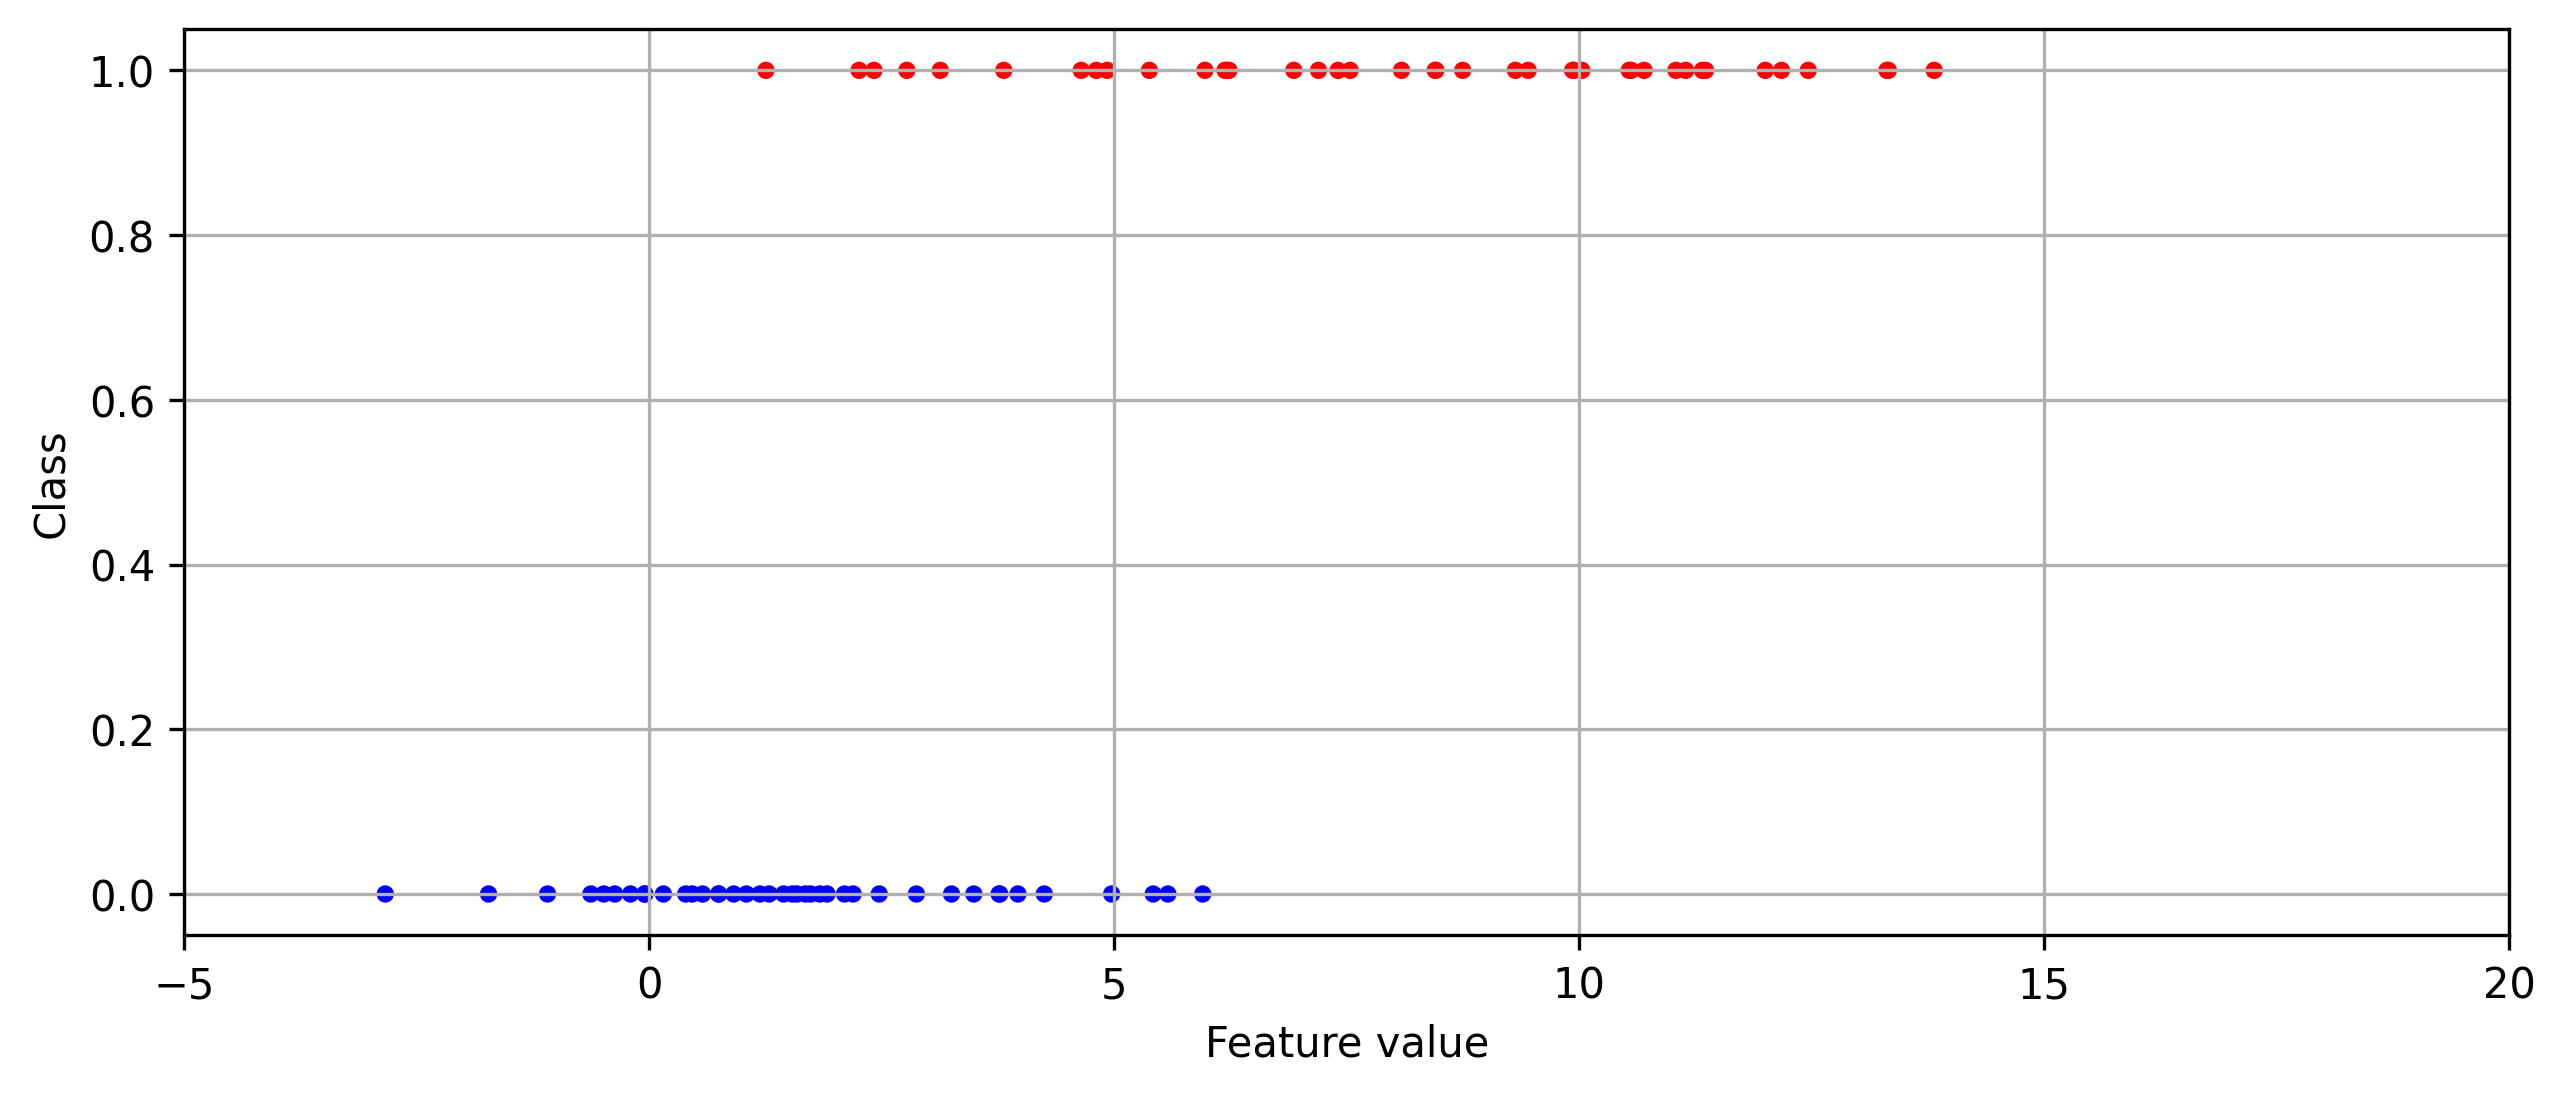

In [114]:
NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2), norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS), np.ones(NUM_PER_CLASS))).astype(int)

plt.figure(figsize=(10, 4), dpi=300)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("Feature value")
plt.ylabel("Class")

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
def lr_model(clf, X):
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

In [117]:
logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %(lr_model(logclf, -1), lr_model(logclf, 7)))

[0.03518544] [2.17570283]
P(x=-1)=0.02	P(x=7)=0.89


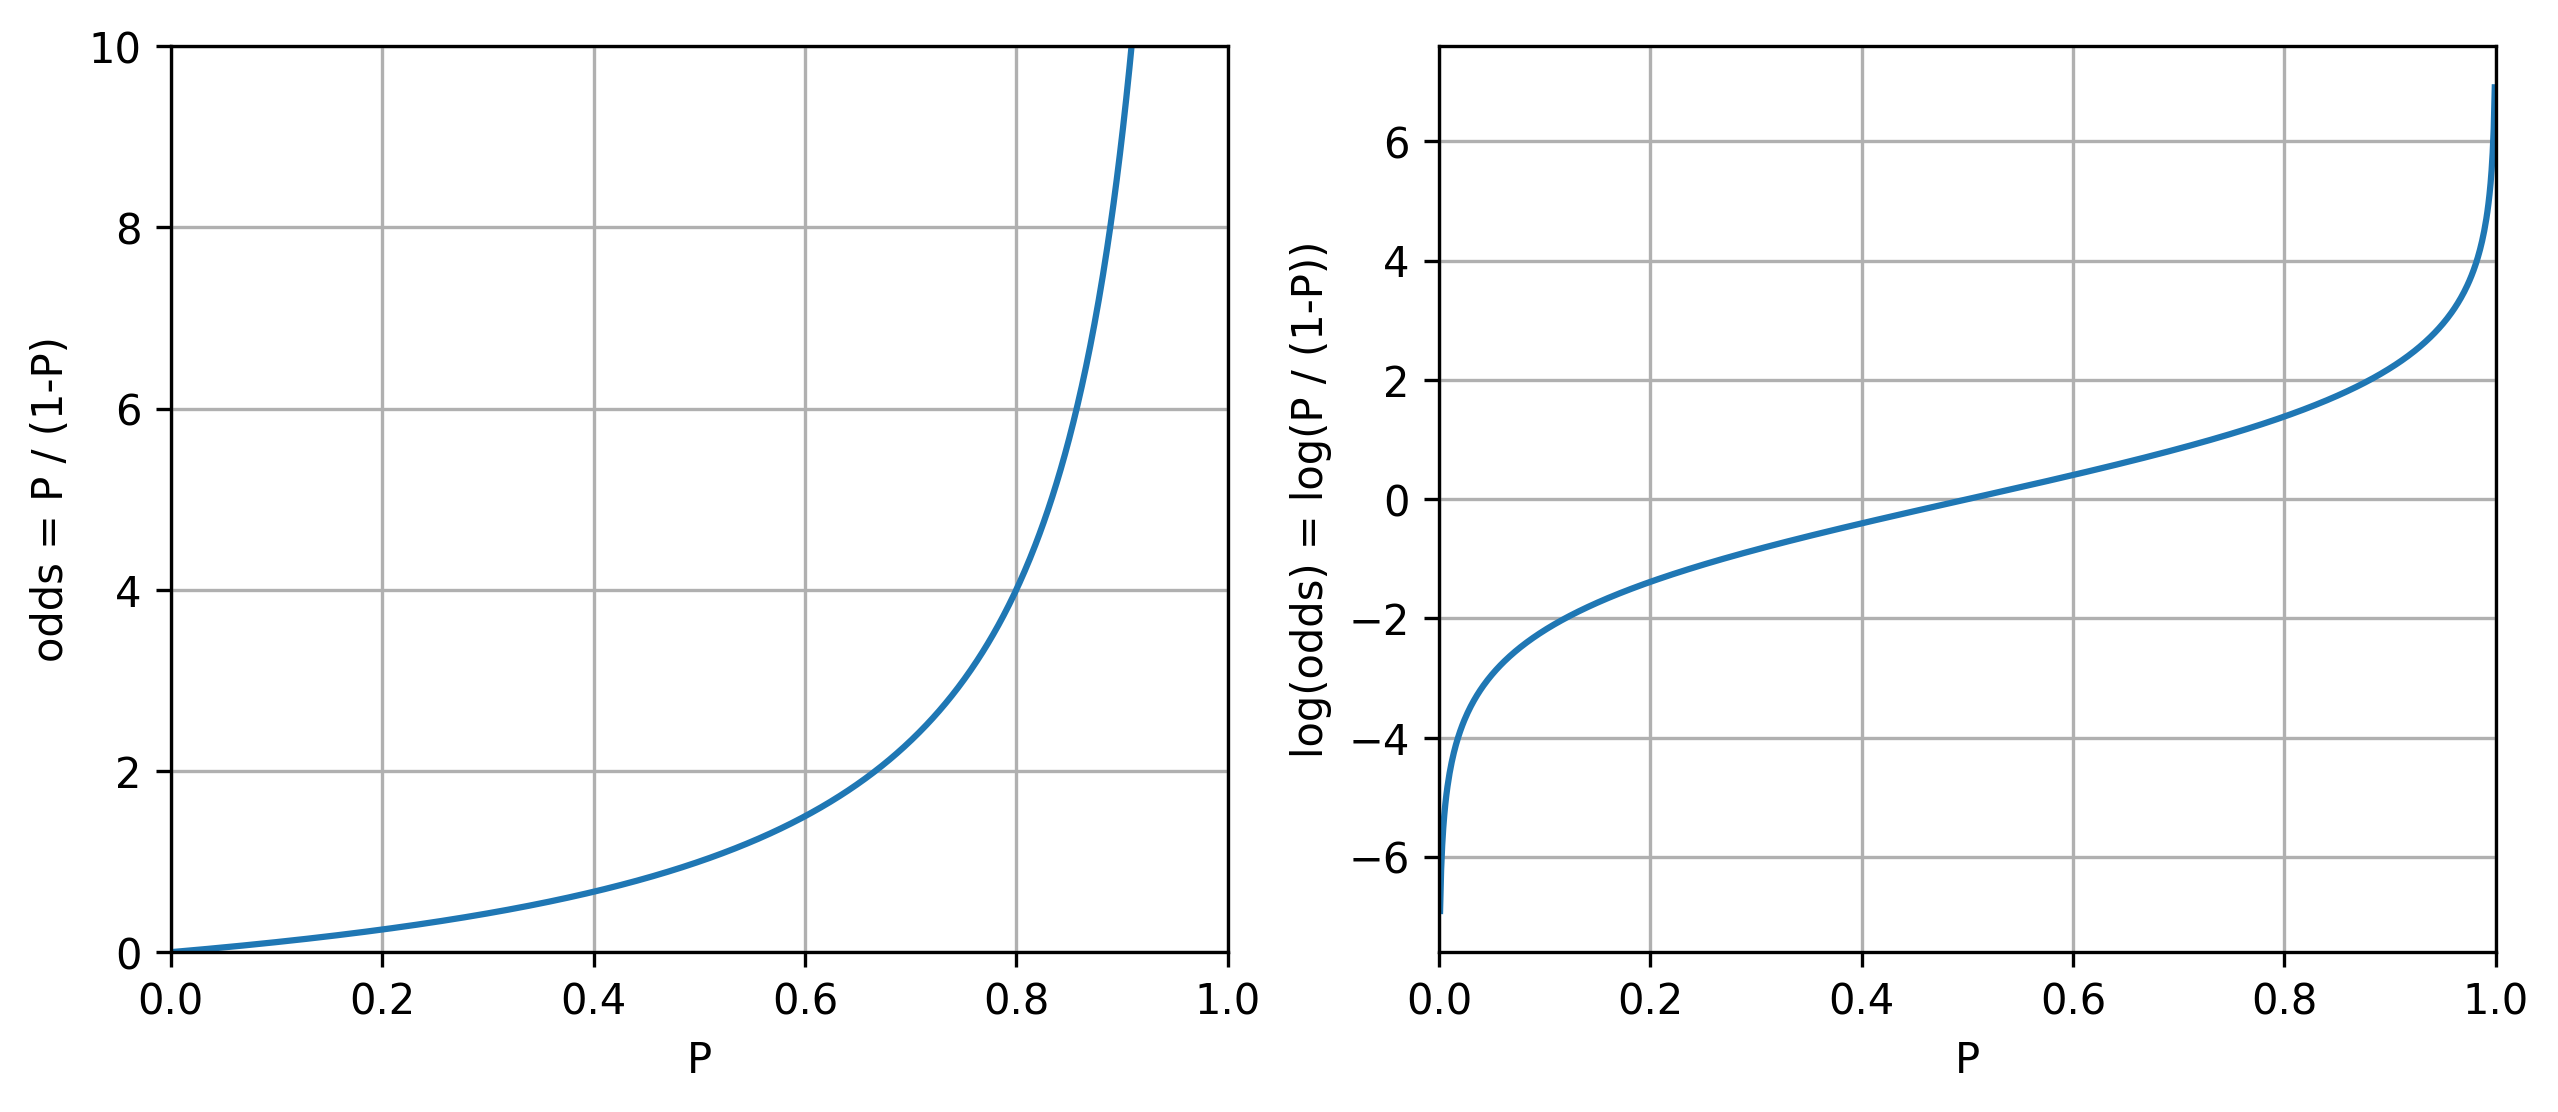

In [118]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)

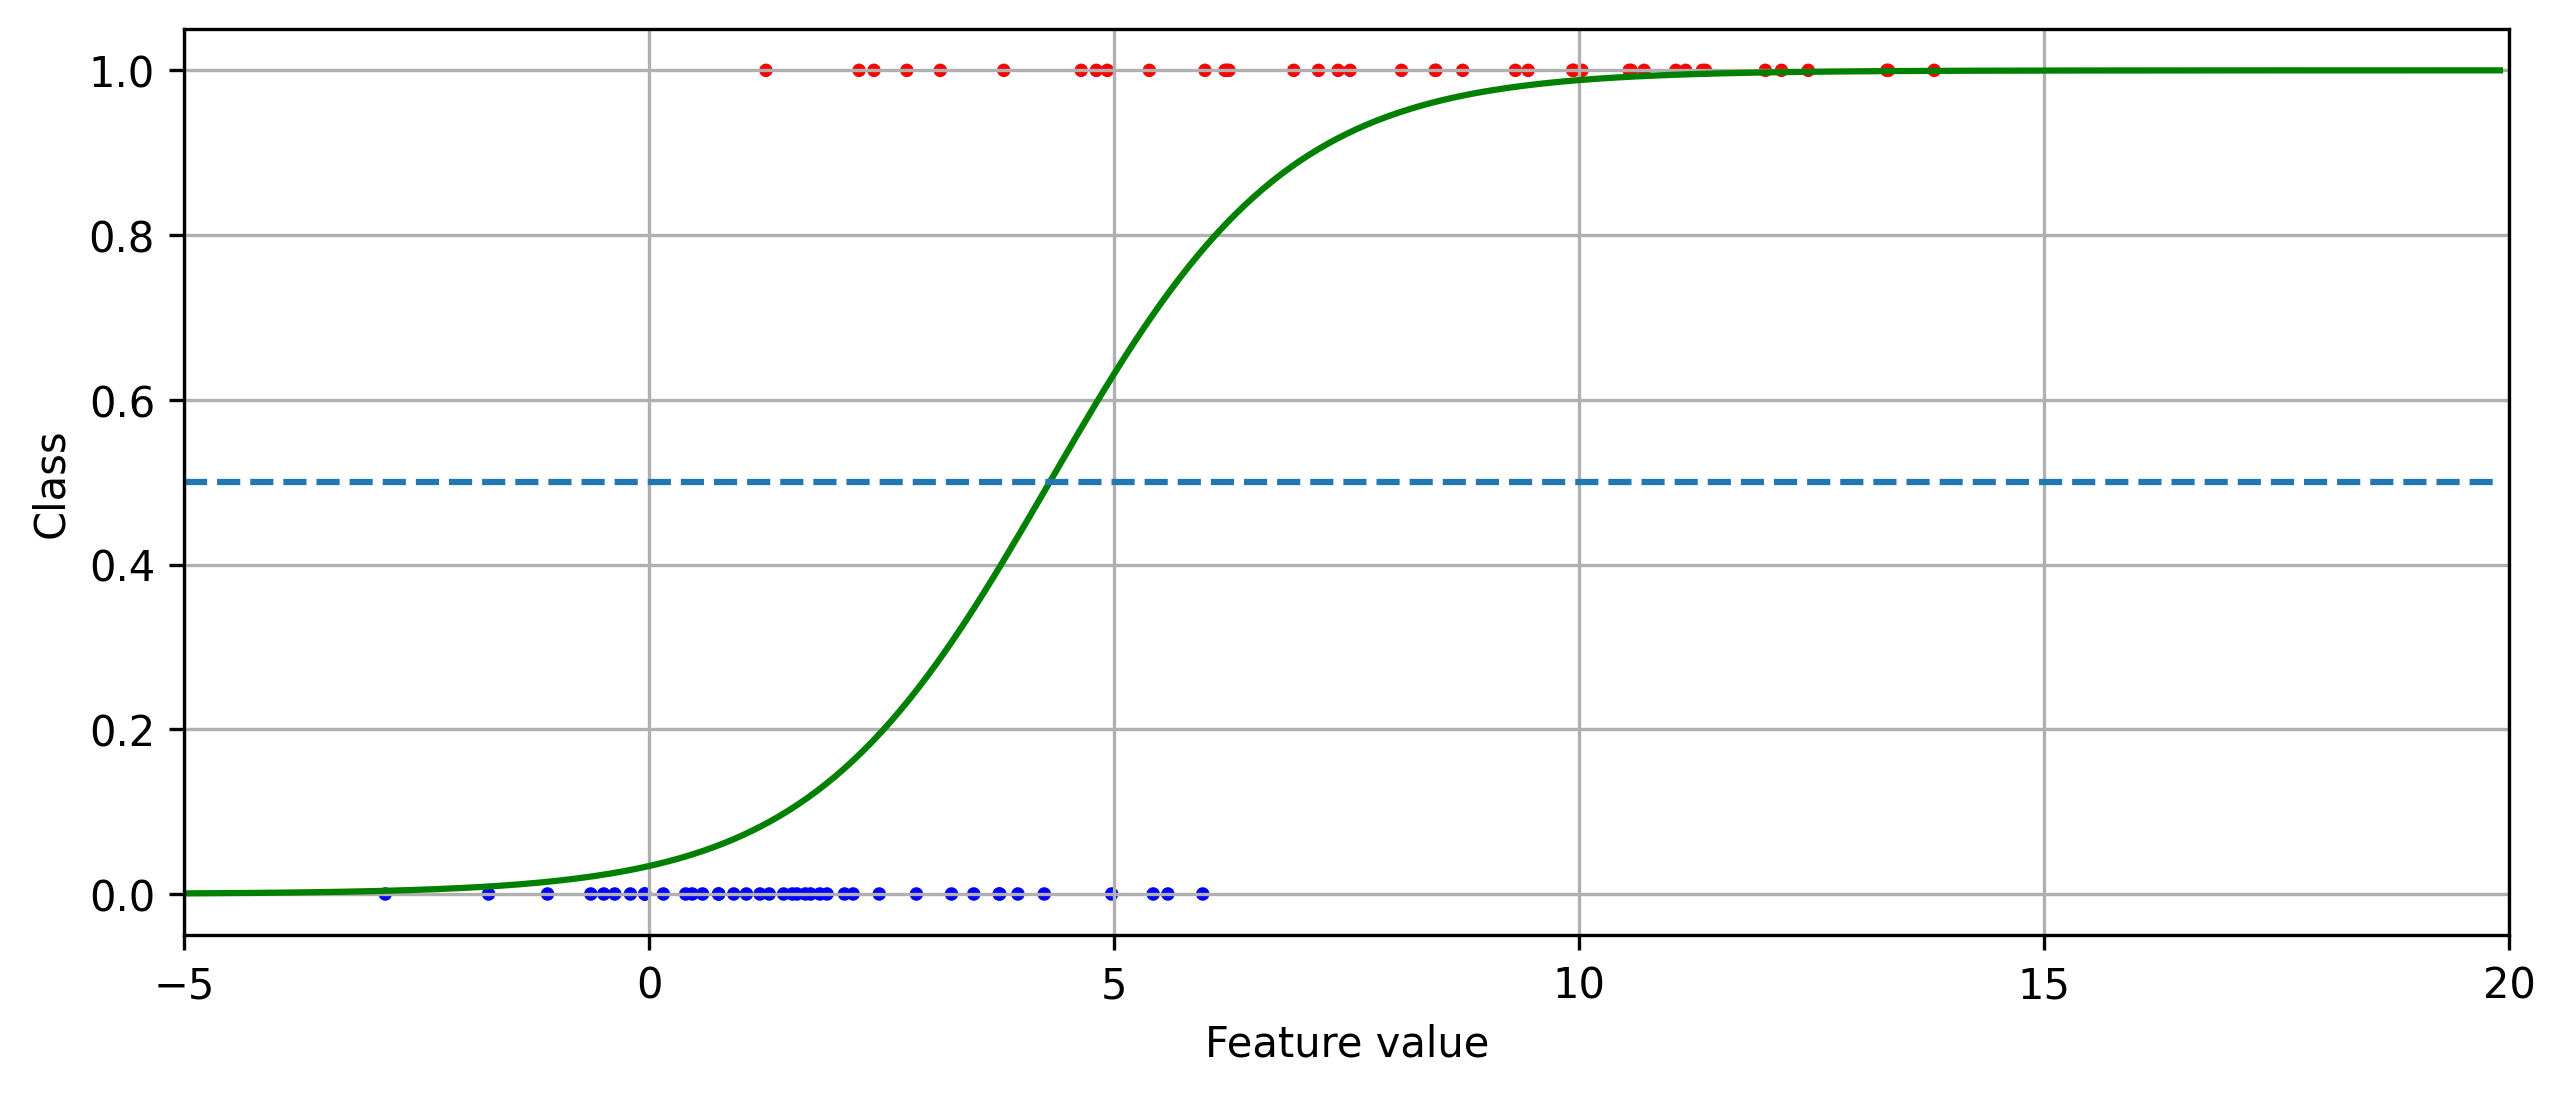

In [119]:
X_range = np.arange(-5, 20, 0.1)

plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
plt.plot(X_range, lr_model(logclf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("Feature value")
plt.ylabel("Class")
plt.grid(True)

## Applying logistic regression to our post classification problem

In [123]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    _, _, summary = measure(LogisticRegression, {'C': C}, name, X, Y)

    print('%5.3f\t%.4f\t\t%.4f' % (C, np.mean(summary['scores']), np.std(summary['scores'])))

C	mean(scores)	stddev(scores)
0.001	0.6318		0.0093
0.010	0.6313		0.0089


c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

0.100	0.6316		0.0091


c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

1.000	0.6315		0.0091


c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

10.000	0.6315		0.0092


c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [124]:
C_best = 0.001

## Looking behind accuracy – precision and recall

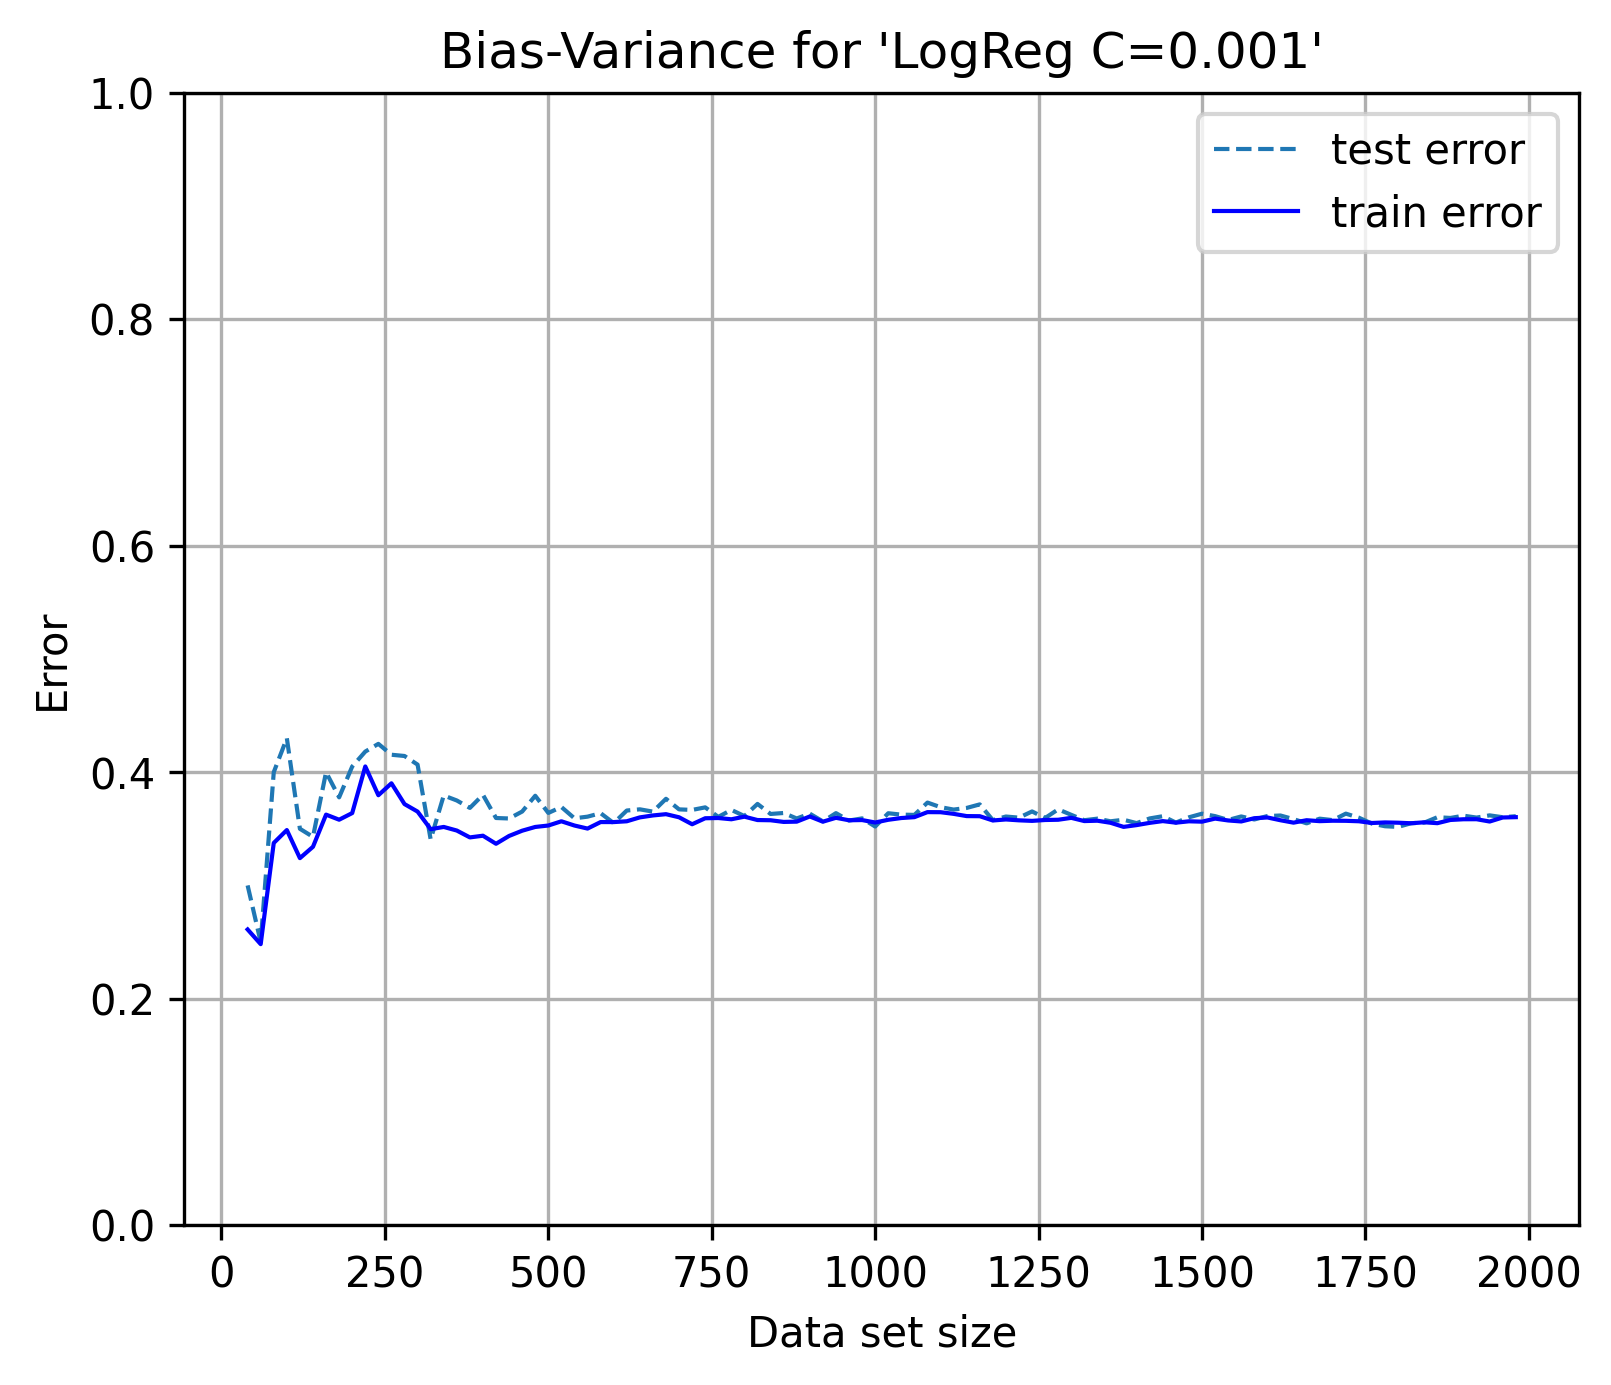

In [126]:
bias_variance_analysis(LogisticRegression, {'C': C_best}, "LogReg C=0.001", X, Y)

Good answers...


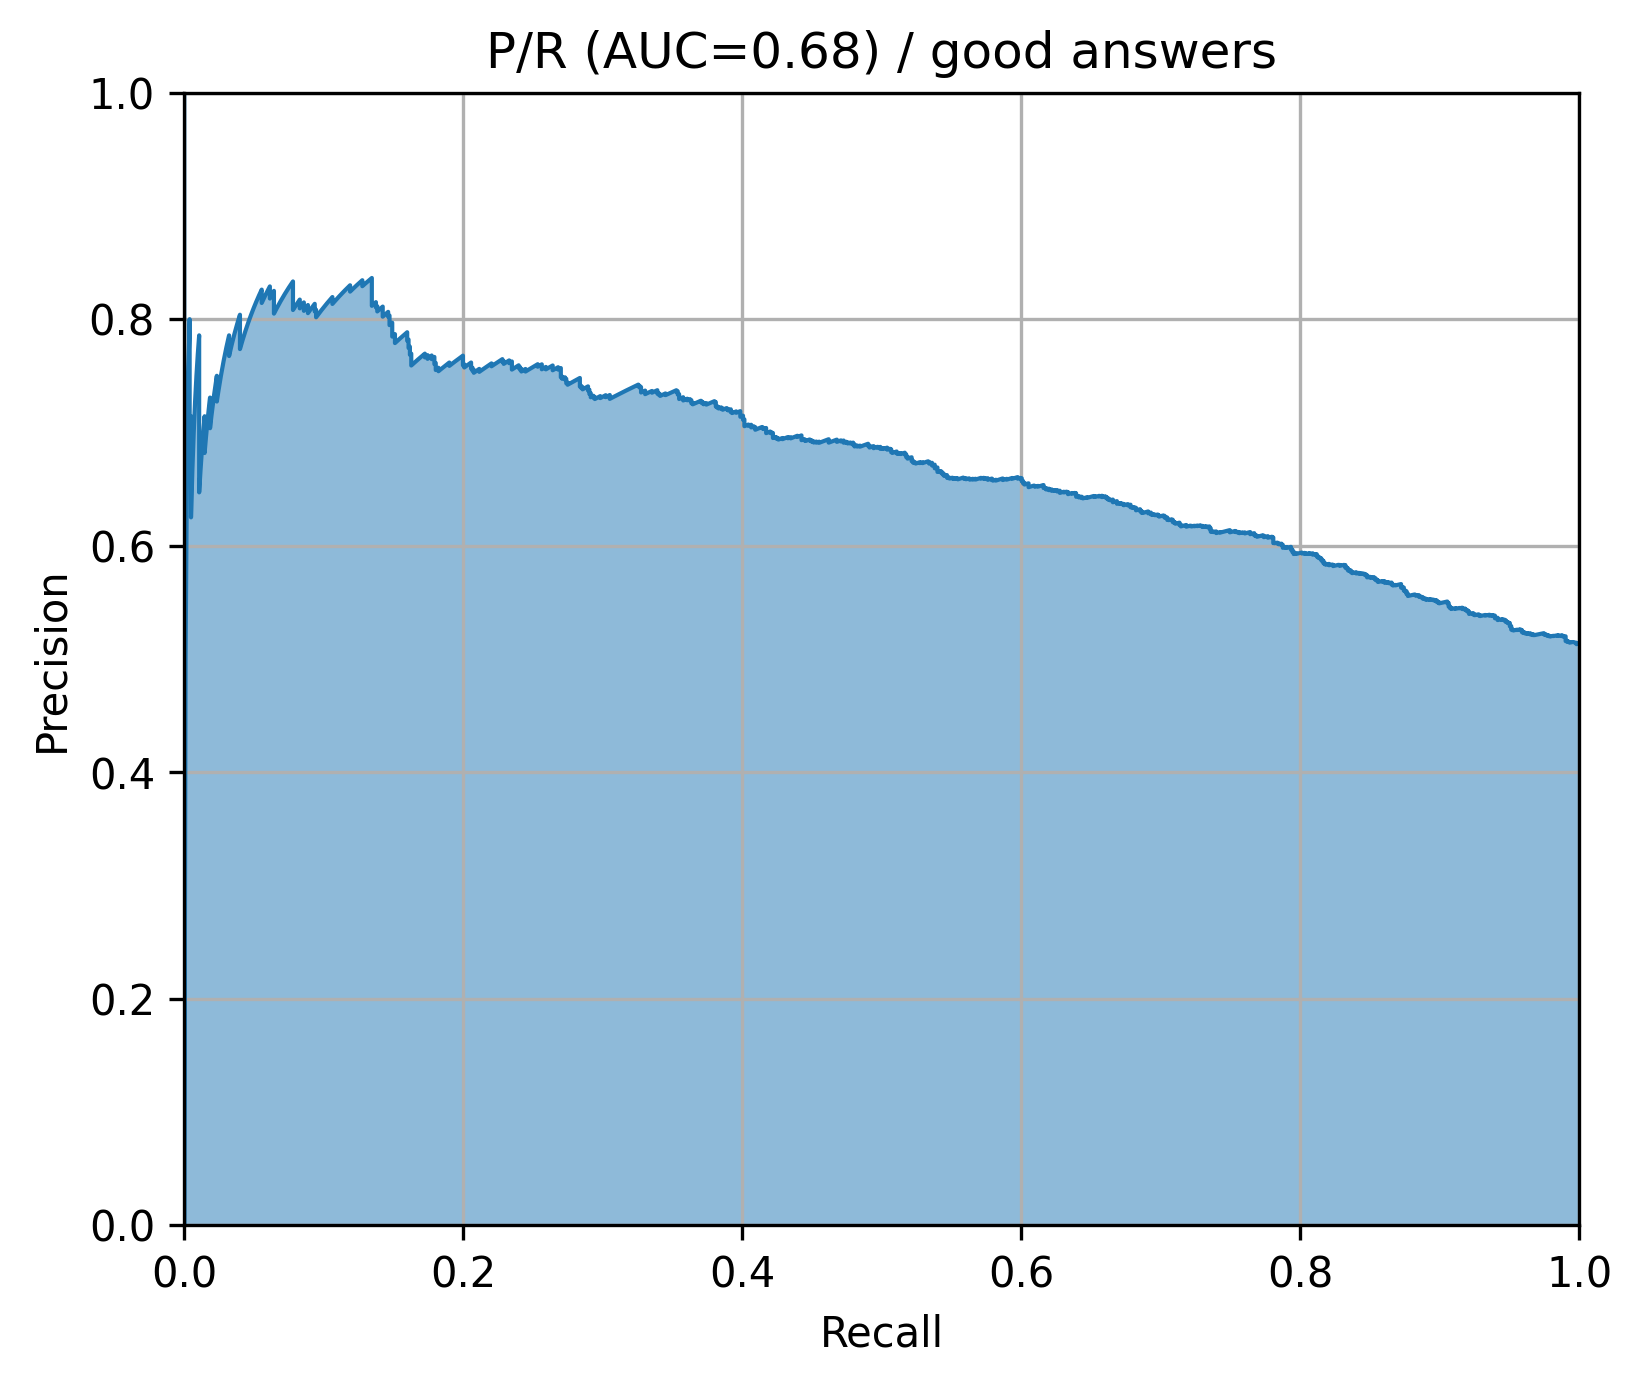

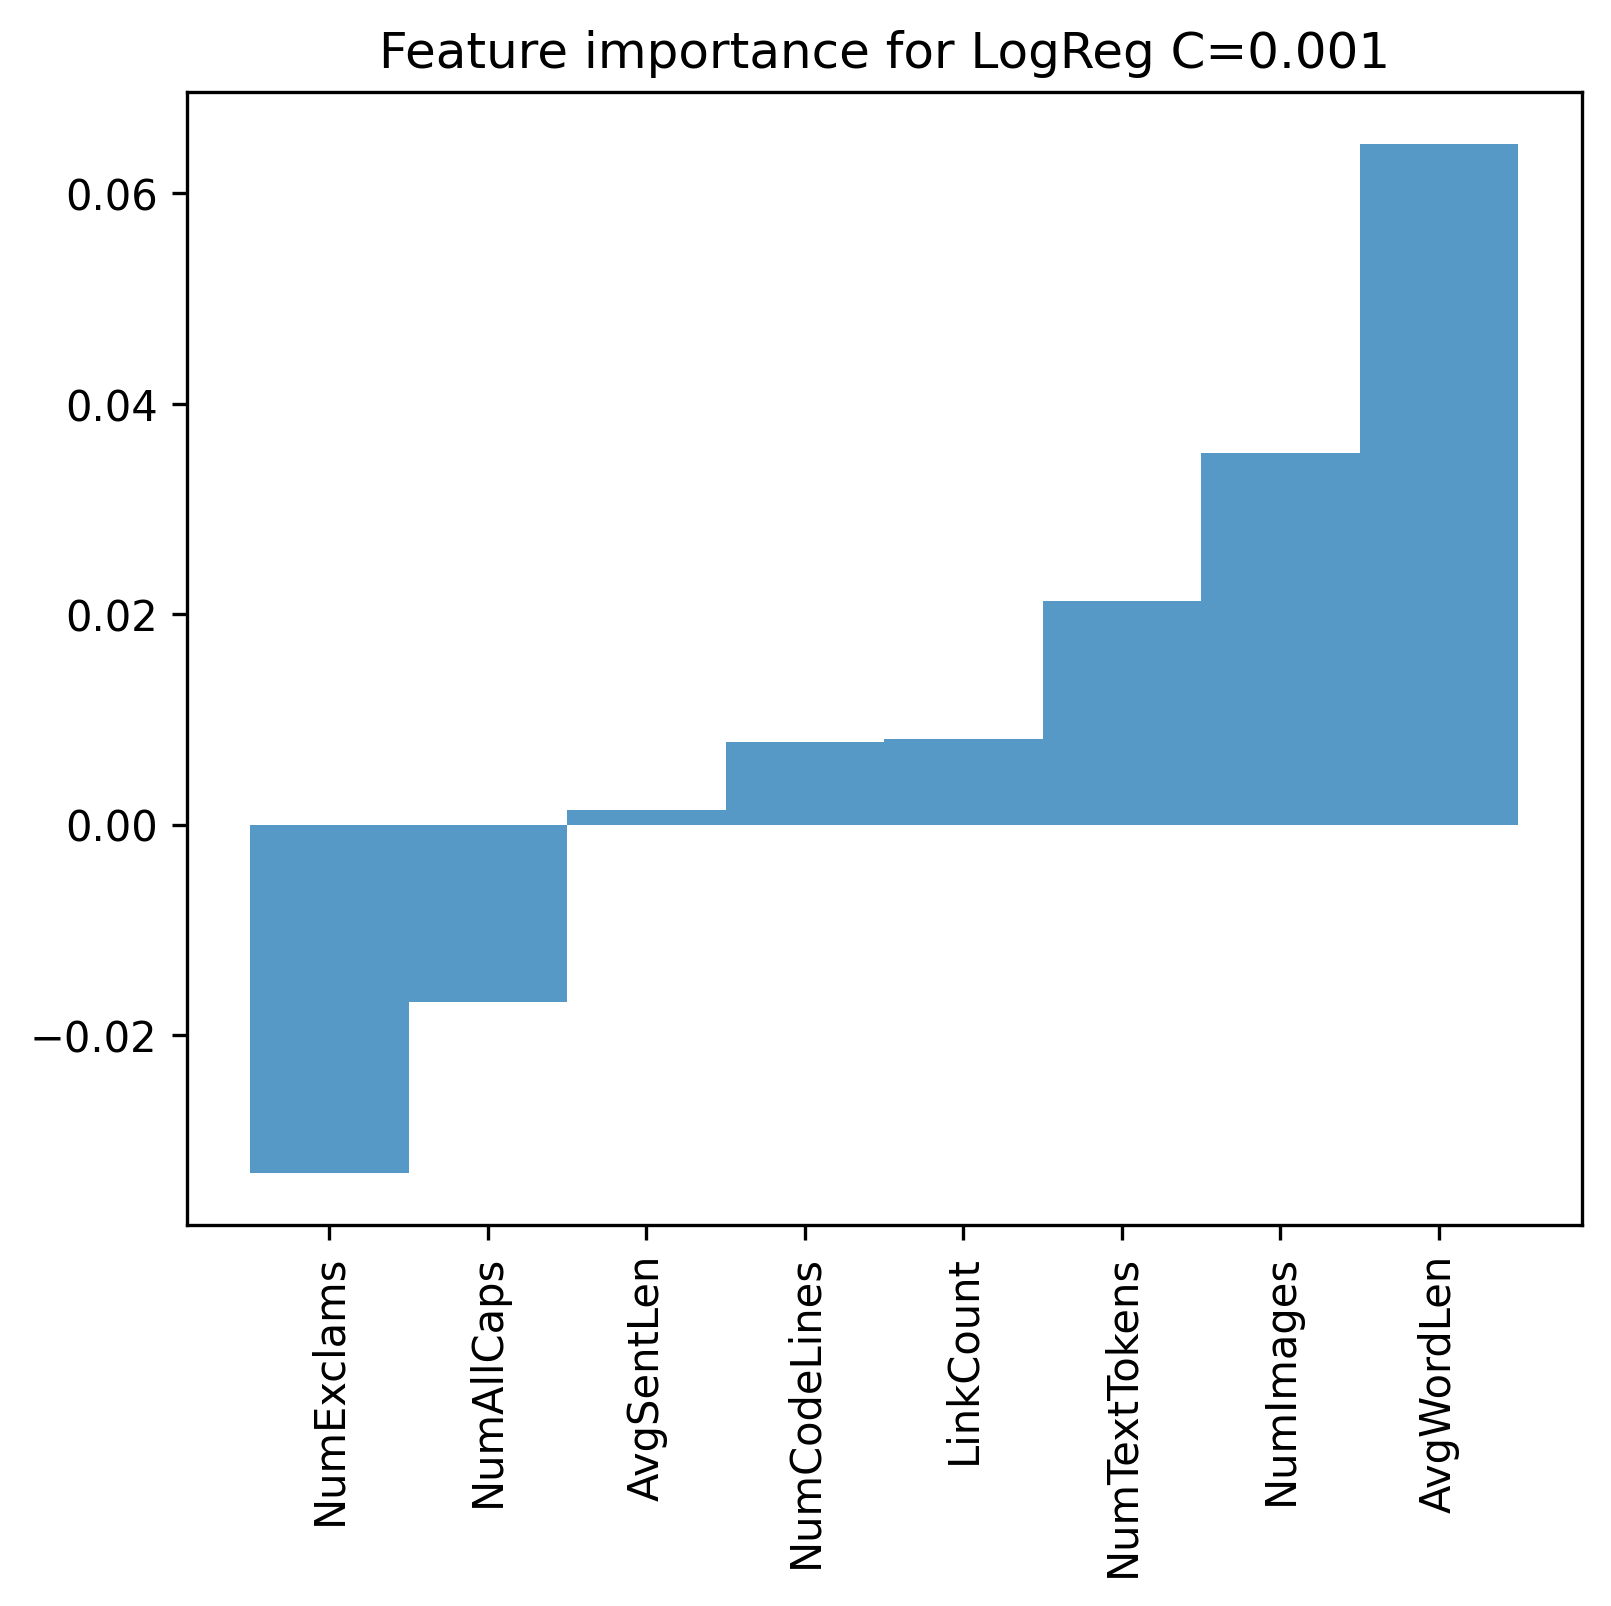

In [141]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams',
    'NumImages'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams', 'NumImages']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = "LogReg C=%.3f" % C_best

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


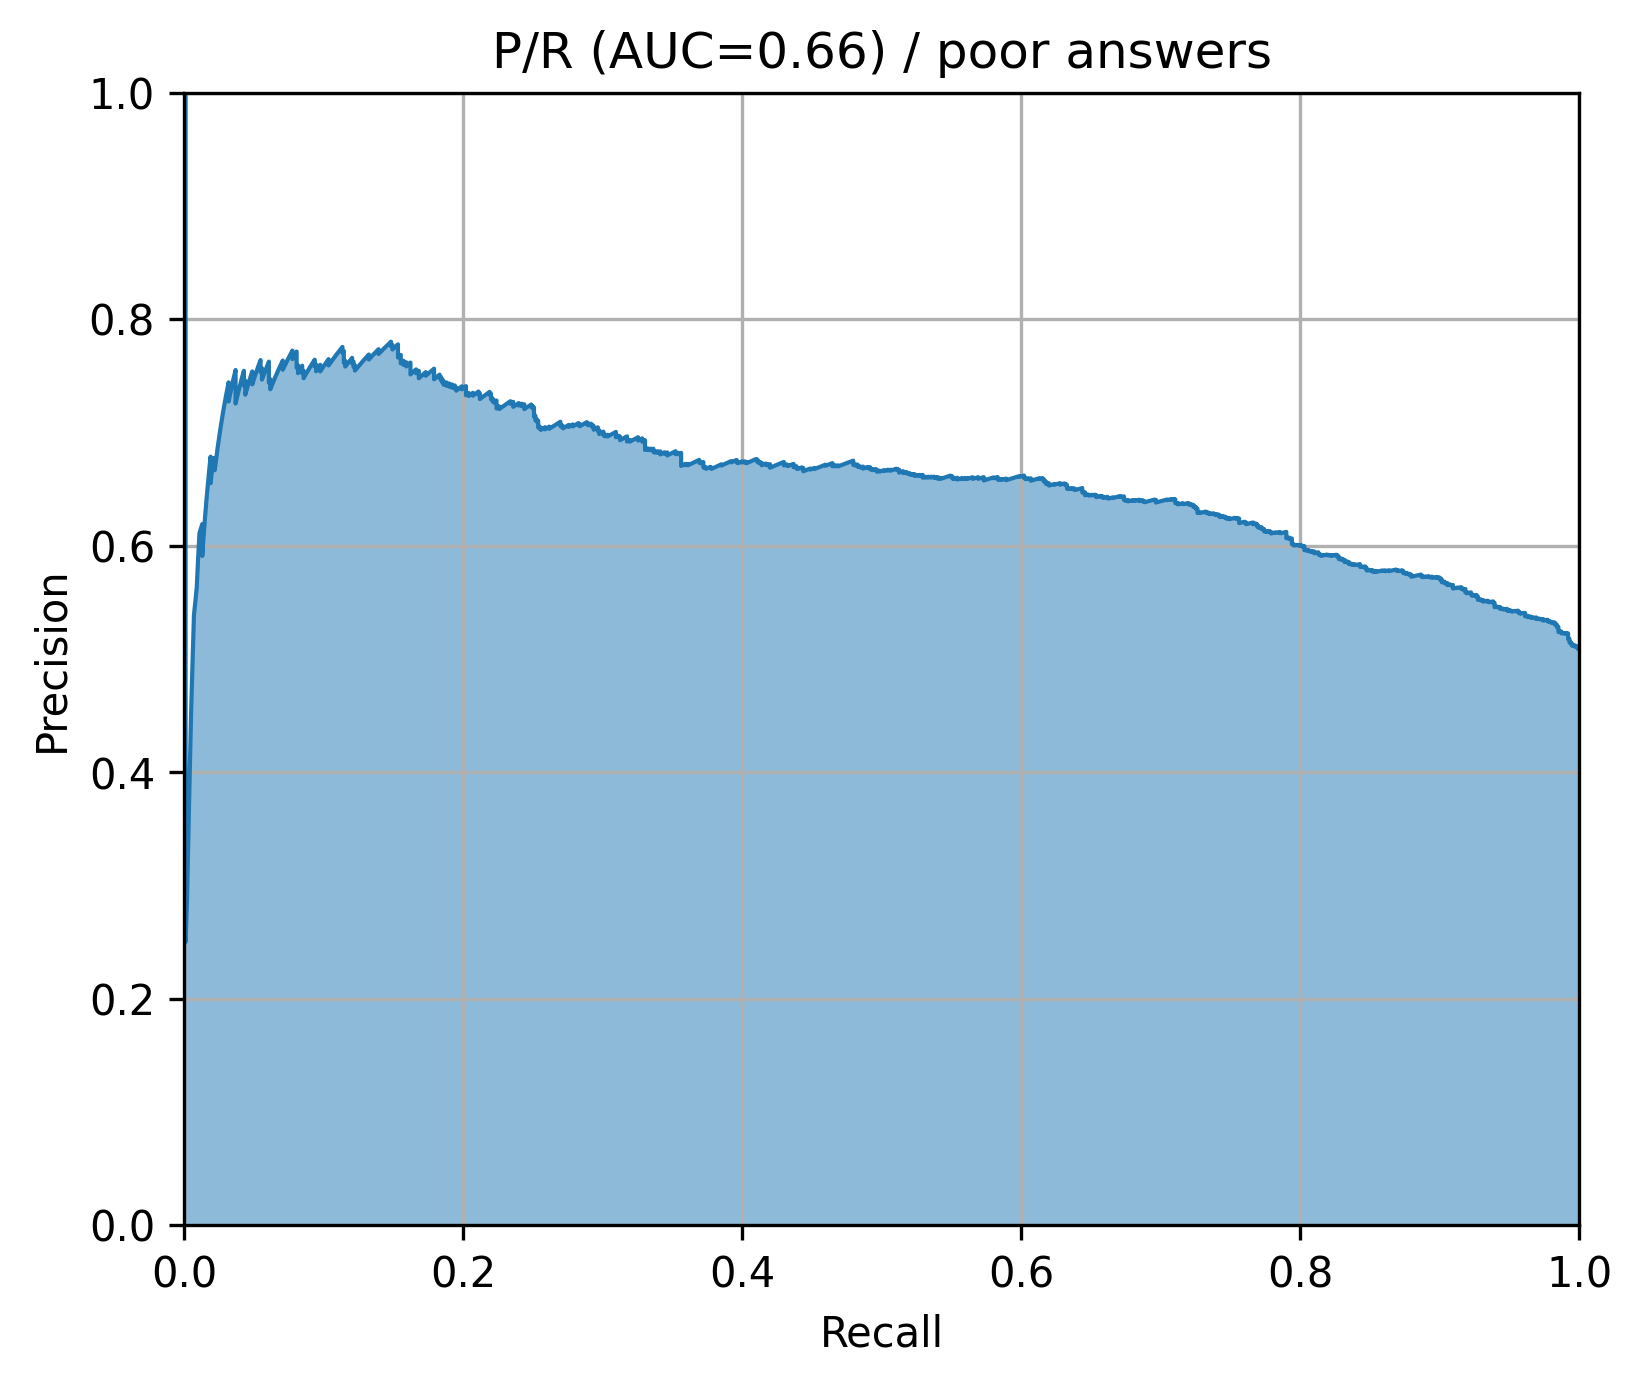

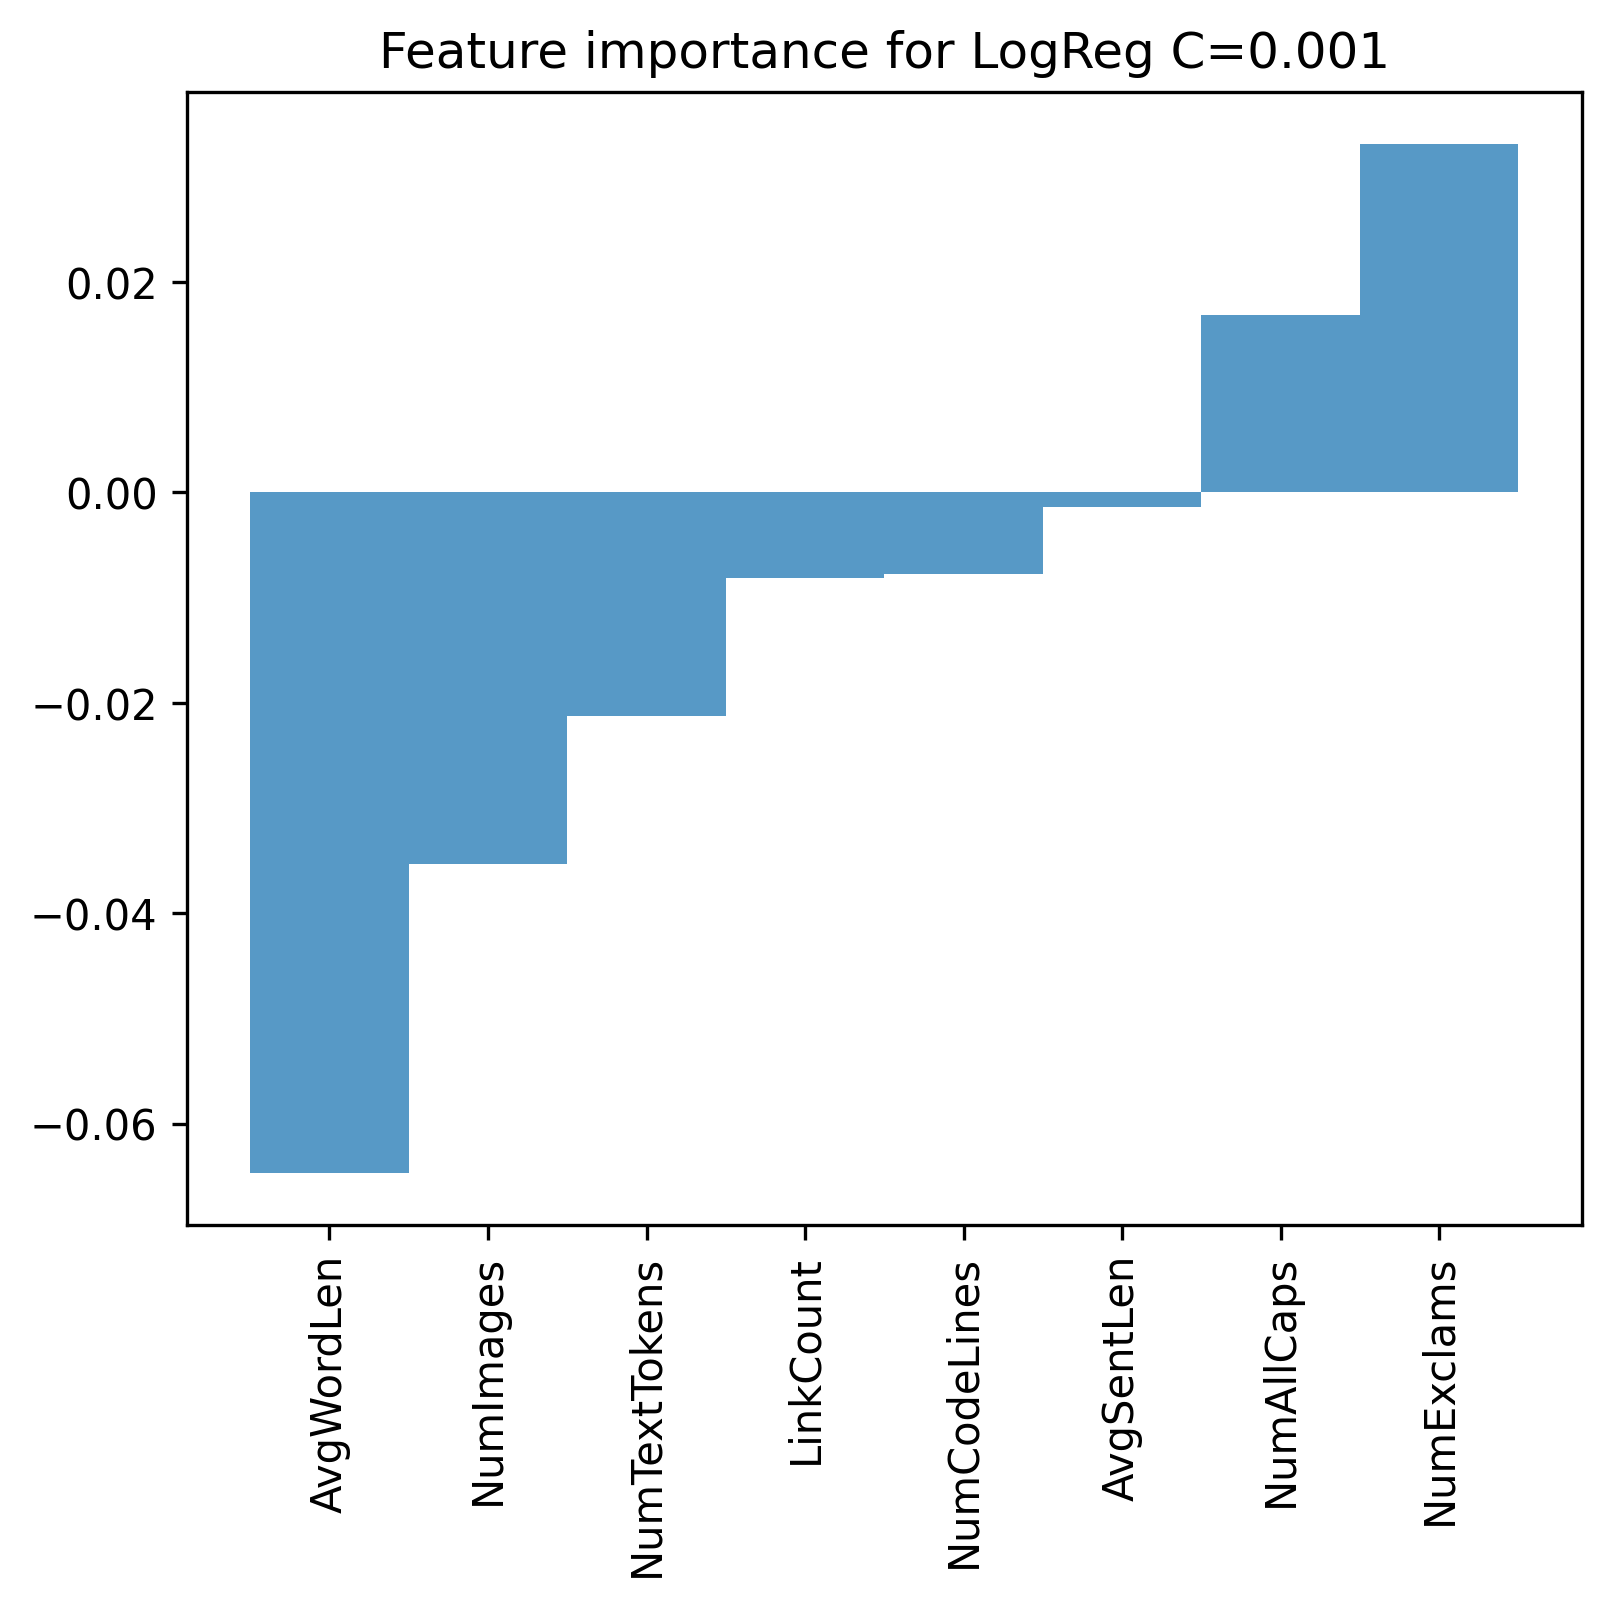

In [142]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

In [143]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))

P=0.77 R=0.16 thresh=0.67
P=0.78 R=0.16 thresh=0.68
P=0.79 R=0.15 thresh=0.69
P=0.80 R=0.15 thresh=0.69


In [144]:
good_thresh = 0.69

## Ship it!

In [145]:
clf = LogisticRegression(C=C_best)
clf.fit(X, Y) # now training on all data without cross-validation
print(clf.coef_)

[[ 0.02033759  0.00808485  0.00823314  0.00169923  0.06621219 -0.01832016
  -0.02943403]]


In [148]:
import pickle
pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_)

[[ 0.02033759  0.00808485  0.00823314  0.00169923  0.06621219 -0.01832016
  -0.02943403]]


We can now use the classifier's `predict_proba()` to calculate the probabilities for the classes `poor` and `good`:

In [152]:
# Remember that the features are in this order:
# LinkCount, NumCodeLines, NumTextTokens, AvgSentLen, AvgWordLen, NumAllCaps, NumExclams
good_post = (2, 1, 100, 5, 4, 1, 0)
poor_post = (1, 0, 10, 5, 6, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
print(proba) # print probabilities (poor, good) per post

[[0.44025412 0.55974588]
 [0.64287549 0.35712451]]


In [153]:
print(proba >= good_thresh)

[[False False]
 [False False]]


## Classification using Tensorflow
#### Neural networks can also be designed with TensorFlow to classify data.

In [163]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [164]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

Let's create two types of layers: one for dense layers, meaning that they connect all input to all output, and one for the output layer that has only one output unit:

In [165]:
def create_dense(x, n_units, name, alpha=0.2):
    # Hidden layer
    h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
    return h

def create_output(x):
    # Output layer
    h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")
    return h

This output unit is created with a sigmoid activation. This means that the inner tf.matmult that creates values between -inf and +inf is fed inside a function that maps these to the interval [0, 1]. 0 and 1 cannot be achieved for the output, so when we train our neural network, we have to keep this in memory.

In [166]:
Y = Y.astype(np.float32)[:, None]
bce_ceil = 1e-5
Y = Y * (1 - 2 * bce_ceil) + bce_ceil

And now, we can split our data:

In [167]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

Let's start with setting our usual hyper parameters:

In [168]:
n_epochs = 500
batch_size = 1000
steps = 10
layer1_size = 5

If we use all seven features, our neural network building looks like this:

In [169]:
X_tf = tf.placeholder(tf.float32, (None, 7), name="Input")
Y_ref_tf = tf.placeholder(tf.float32, (None, 1), name="Target_output")

h1 = create_dense(X_tf, layer1_size, name="Layer1")
Y_tf = create_output(h1)

loss = tf.reduce_mean(tf.square(Y_ref_tf - Y_tf))

grad_speed = .01
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


The gradient step is now far greater than the one from the regression example.
We can now train our neural network.

In [170]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_vec = []
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(X_train))
        for j in range(0, len(X_train), batch_size):
            batch = permut[j:j+batch_size]
            Xs = X_train[batch]
            Ys = Y_train[batch]
            
            sess.run(train_step, feed_dict={X_tf: Xs, Y_ref_tf: Ys})
        
        temp_loss = sess.run(loss, feed_dict={X_tf: X_train, Y_ref_tf: Y_train})
        loss_vec.append(temp_loss)
        if epoch % steps == steps - 1:
            print('Epoch #%i  loss = %s' % (epoch, temp_loss))

    predict_train = sess.run(Y_tf, feed_dict={X_tf: X_train})
    predict_test = sess.run(Y_tf, feed_dict={X_tf: X_test})

Epoch #9  loss = 0.36287263
Epoch #19  loss = 0.31708524
Epoch #29  loss = 0.23934244
Epoch #39  loss = 0.24077243
Epoch #49  loss = 0.25208387
Epoch #59  loss = 0.2426562
Epoch #69  loss = 0.22929983
Epoch #79  loss = 0.22815154
Epoch #89  loss = 0.22805294
Epoch #99  loss = 0.22793144
Epoch #109  loss = 0.2283316
Epoch #119  loss = 0.22851351
Epoch #129  loss = 0.22996838
Epoch #139  loss = 0.2276778
Epoch #149  loss = 0.22761099
Epoch #159  loss = 0.22791599
Epoch #169  loss = 0.22887653
Epoch #179  loss = 0.22737089
Epoch #189  loss = 0.22731586
Epoch #199  loss = 0.22717334
Epoch #209  loss = 0.22974688
Epoch #219  loss = 0.22711825
Epoch #229  loss = 0.23244558
Epoch #239  loss = 0.22897255
Epoch #249  loss = 0.22727667
Epoch #259  loss = 0.23030294
Epoch #269  loss = 0.22814806
Epoch #279  loss = 0.22821213
Epoch #289  loss = 0.23041205
Epoch #299  loss = 0.22711624
Epoch #309  loss = 0.22668996
Epoch #319  loss = 0.22685617
Epoch #329  loss = 0.22827159
Epoch #339  loss = 0.227

### Displaying how well the optimizer behaved:

Text(0, 0.5, 'Loss')

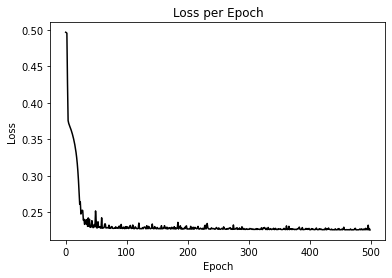

In [171]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

If we look at the scores for the training and the test scores, we can see that we have results that match the best of the previous classifiers:

In [172]:
from sklearn.metrics import accuracy_score

score = accuracy_score(Y_train > .5, predict_train > .5)
print("Score (on training data): %.2f" % score)
score = accuracy_score(Y_test > .5, predict_test > .5)
print("Score (on testing data): %.2f" % score)

Score (on training data): 0.64
Score (on testing data): 0.64


A nice feature of sklearn is the abundance of support functions and tutorials. This is a function from a tutorial on confusion matrices that helps visualize the quality of a classifier:

In [173]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We can now use it with a threshold at .5 to see the behavior of this classifier on trained and tested data:

              precision    recall  f1-score   support

        Poor       0.61      0.73      0.67      7979
        Good       0.67      0.54      0.60      8021

    accuracy                           0.64     16000
   macro avg       0.64      0.64      0.63     16000
weighted avg       0.64      0.64      0.63     16000

Confusion matrix, without normalization
[[5860 2119]
 [3688 4333]]


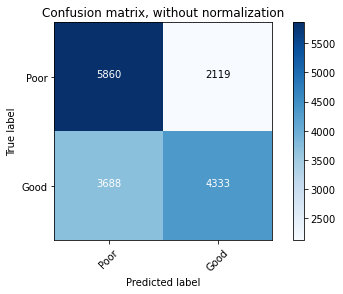

              precision    recall  f1-score   support

        Poor       0.62      0.73      0.67      2021
        Good       0.66      0.54      0.60      1979

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.63      4000
weighted avg       0.64      0.64      0.64      4000

Confusion matrix, without normalization
[[1476  545]
 [ 901 1078]]


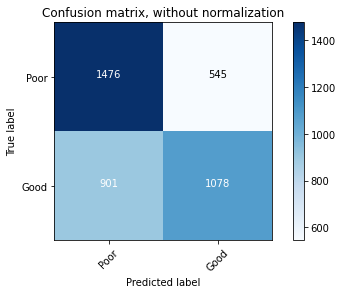

In [175]:
class_names = ["Poor", "Good"]

from sklearn import metrics

print(metrics.classification_report(Y_train > .5, predict_train > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_train > .5, predict_train > .5), classes=class_names,
                      title='Confusion matrix, without normalization')

plt.grid(False)

plt.show()

print(metrics.classification_report(Y_test > .5, predict_test > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_test > .5, predict_test > .5), classes=class_names,
                      title='Confusion matrix, without normalization')

plt.grid(False)